# ML match for LOFAR and the combined PanSTARRS WISE catalogue: Source catalogue

## Configuration

### Load libraries and setup

In [1]:
import numpy as np
import astropy
from astropy.table import Table, Column,join,vstack
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
from IPython.display import clear_output
import pickle
import os
from glob import glob
from shutil import copyfile
from pymoc import MOC
from pymoc.util import catalog
import matplotlib.patches as mpatches

In [3]:
from mltier import (get_center, get_n_m, estimate_q_m, Field, SingleMLEstimator, MultiMLEstimator,
                     parallel_process, get_sigma_all, get_q_m, get_threshold, q0_min_level, q0_min_numbers,
                     get_n_m_kde, estimate_q_m_kde, get_q_m_kde, describe)
from Q0_calc import Q0_calc

In [4]:
%load_ext autoreload

In [5]:
%autoreload

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/im281/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['vstack']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### General configuration

In [7]:
save_intermediate = True
plot_intermediate = True

## Load data

In [8]:
combined_all = Table.read('data/Lockman-SWIRE_20180219.fits')

We will start to use the updated catalogues that include the output of the LOFAR Galaxy Zoo work.

In [13]:
#lofar_all = Table.read("data/LOFAR_HBA_T1_DR1_catalog_v0.9.srl.fits")
lofar_all = Table.read('data/deep-lockman-v0.1.cat.fits')

In [14]:
#np.array(combined_all.colnames)

In [15]:
#np.array(lofar_all.colnames)

In [16]:
describe(lofar_all['Maj'])

0.003 +/- 0.002; median: 0.002; limits: [0.001, 0.071]; N=37165 (0 NaN; 0 masked)


# Field

In [44]:
# read in the moc for the field used
# alternatively a moc could be created that covers a specific subset of masterlist sources (such as IRAC sources).

#mask = ~np.isnan(combined_all['f_gpc1_i'])
#irac_sources = combined_all[mask]
#irac_coords = SkyCoord(irac_sources['ra'],irac_sources['dec'])
#irac_masterlist_moc = catalog.catalog_to_moc(irac_coords,10,11)
#MHz150_MOC = irac_masterlist_moc

MOC_loc = 'mocs/PanSTARRS1-3SS_Lockman-SWIRE_v2_MOC.fits'
MHz150_MOC = MOC(filename=MOC_loc)

In [45]:
ra_down, ra_up, dec_down, dec_up = min(lofar_all['RA']),max(lofar_all['RA']),min(lofar_all['DEC']),max(lofar_all['DEC'])
field = Field(ra_down, ra_up, dec_down, dec_up, MHz150_MOC)

field area is defined by a MOC


### Filter catalogues

We will take the sources in the main region but also discard sources with a Major axis size bigger than 30 arsecs. We will also discard all the sources that are not classified with the code 1 in "ID_flag". Henceforth, we only take sources marked as "ML" only.

In [46]:
lofar_aux = lofar_all[~np.isnan(lofar_all['Maj'])]

In [47]:
lofar = field.filter_catalogue(lofar_aux[(lofar_aux['Maj'] < 30.)], 
                               colnames=("RA", "DEC"))

filtering in a MOC


In [48]:
lofar_full = field.filter_catalogue(lofar_aux[(lofar_aux['Maj'] < 30.)], 
                                         colnames=("RA", "DEC"))

filtering in a MOC


In [49]:
combined = field.filter_catalogue(combined_all, 
                               colnames=("ra", "dec"))

filtering in a MOC


### Additional data

In [50]:
combined["colour"] = combined["m_gpc1_i"] - combined["m_irac_i1"]

In [51]:
combined_aux_index = np.arange(len(combined))

### Sky coordinates

In [52]:
coords_combined = SkyCoord(combined['ra'], 
                           combined['dec'], 
                           unit=(u.deg, u.deg), 
                           frame='icrs')

In [53]:
coords_lofar = SkyCoord(lofar['RA'], 
                       lofar['DEC'], 
                       unit=(u.deg, u.deg), 
                       frame='icrs')

### Class of sources in the combined catalogue

The sources are grouped depending on the available photometric data.

In [54]:
combined_matched = (~np.isnan(combined['m_gpc1_i']) & ~np.isnan(combined['m_irac_i1'])) # Matched i-W1 sources

In [55]:
combined_panstarrs = (~np.isnan(combined['m_gpc1_i']) & np.isnan(combined['m_irac_i1'])) # Sources with only i-band

In [56]:
combined_wise =(np.isnan(combined['m_gpc1_i']) & ~np.isnan(combined['m_irac_i1'])) # Sources with only W1-band

In [57]:
combined_i = combined_matched | combined_panstarrs
combined_w1 = combined_matched | combined_wise
#combined_only_i = combined_panstarrs & ~combined_matched
#combined_only_w1 = combined_wise & ~combined_matched

In [58]:
print("Total    - ", len(combined))
print("i and W1 - ", np.sum(combined_matched))
print("Only i   - ", np.sum(combined_panstarrs))
print("With i   - ", np.sum(combined_i))
print("Only W1  - ", np.sum(combined_wise))
print("With W1  - ", np.sum(combined_w1))

Total    -  4270653
i and W1 -  204205
Only i   -  223884
With i   -  428089
Only W1  -  812488
With W1  -  1016693


### Colour categories

The colour categories will be used after the first ML match

In [59]:
colour_limits = [0.0, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5, 4.0]

In [60]:
# Start with the W1-only, i-only and "less than lower colour" bins
colour_bin_def = [{"name":"only W1", "condition": combined_wise},
                  {"name":"only i", "condition": combined_panstarrs},
                  {"name":"-inf to {}".format(colour_limits[0]), 
                   "condition": (combined["colour"] < colour_limits[0])}]

# Get the colour bins
for i in range(len(colour_limits)-1):
    name = "{} to {}".format(colour_limits[i], colour_limits[i+1])
    condition = ((combined["colour"] >= colour_limits[i]) & 
                 (combined["colour"] < colour_limits[i+1]))
    colour_bin_def.append({"name":name, "condition":condition})

# Add the "more than higher colour" bin
colour_bin_def.append({"name":"{} to inf".format(colour_limits[-1]), 
                       "condition": (combined["colour"] >= colour_limits[-1])})

/Users/im281/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/Users/im281/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)


In [61]:
combined["category"] = np.nan
for i in range(len(colour_bin_def)):
    combined["category"][colour_bin_def[i]["condition"]] = i

In [62]:
np.sum(np.isnan(combined["category"]))

3030076

We get the number of sources of the combined catalogue in each colour category. It will be used at a later stage to compute the $Q_0$ values

In [63]:
numbers_combined_bins = np.array([np.sum(a["condition"]) for a in colour_bin_def])

In [64]:
numbers_combined_bins

array([812488, 223884,  45689,  40130,  40736,  17939,  15844,  13291,
        10625,   7823,   5276,   3231,   1799,   1385,    299,    138])

## Description

### Sky coverage

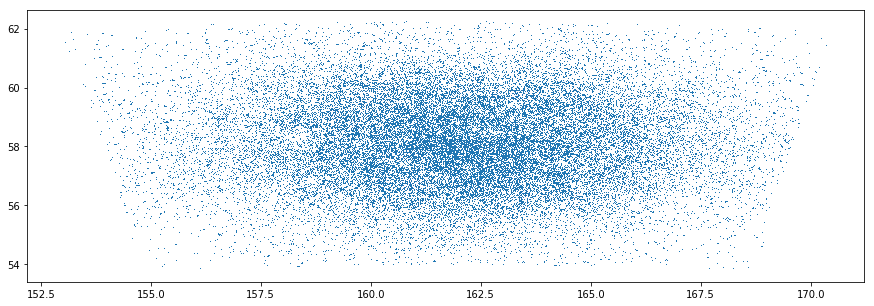

In [65]:
plt.rcParams["figure.figsize"] = (15,5)
plot(lofar_all["RA"],
     lofar_all["DEC"],
     ls="", marker=",");

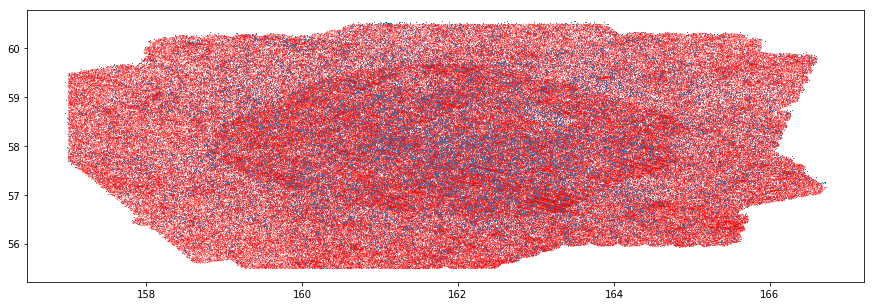

In [71]:
plt.rcParams["figure.figsize"] = (15,5)
plot(lofar_full["RA"],
     lofar_full["DEC"],
     ls="", marker=",");
mask = ~np.isnan(combined['m_gpc1_i'])
scatter(combined['ra'][mask],
     combined['dec'][mask],
     s=0.01,color='red')

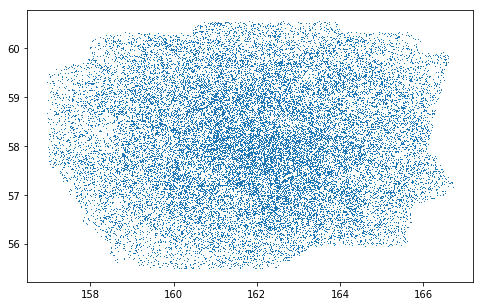

In [72]:
plt.rcParams["figure.figsize"] = (8,5)
plot(lofar["RA"],
     lofar["DEC"],
     ls="", marker=",");

In [73]:
len(lofar)

27875

### Summary of galaxy types in the combined catalogue

In [74]:
np.sum(combined_matched) # Matches

204205

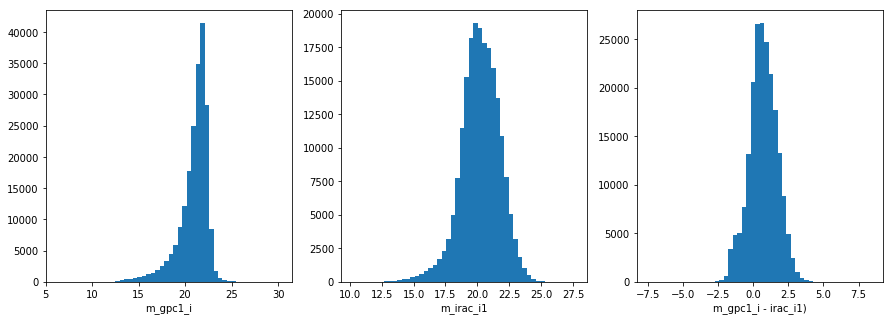

In [76]:
plt.rcParams["figure.figsize"] = (15,5)
subplot(1,3,1)
hist(combined['m_gpc1_i'][combined_matched], bins=50)
xlabel("m_gpc1_i")
subplot(1,3,2)
hist(combined['m_irac_i1'][combined_matched], bins=50)
xlabel('m_irac_i1')
subplot(1,3,3)
hist((combined['m_gpc1_i'] - combined['m_irac_i1'])[combined_matched], bins=50)
xlabel("m_gpc1_i - irac_i1)");

In [77]:
np.sum(combined_panstarrs) # Only PanSTARSS

223884

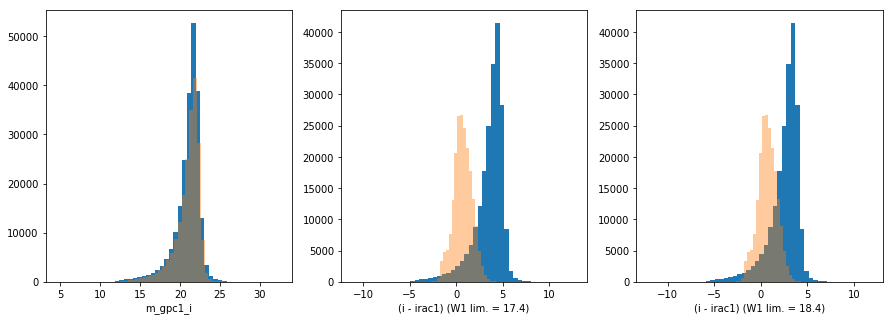

In [78]:
plt.rcParams["figure.figsize"] = (15,5)
subplot(1,3,1)
hist(combined["m_gpc1_i"][combined_panstarrs], bins=50)
hist(combined["m_gpc1_i"][combined_matched], bins=50, alpha=0.4)
xlabel("m_gpc1_i")
subplot(1,3,2)
hist((combined["m_gpc1_i"] - 17.4)[combined_matched], bins=50)
hist((combined["m_gpc1_i"] - combined["m_irac_i1"])[combined_matched], bins=50, alpha=0.4)
xlabel("(i - irac1) (W1 lim. = 17.4)")
subplot(1,3,3)
hist((combined["m_gpc1_i"] - 18.4)[combined_matched], bins=50)
hist((combined["m_gpc1_i"] - combined["m_irac_i1"])[combined_matched], bins=50, alpha=0.4)
xlabel("(i - irac1) (W1 lim. = 18.4)");

In [79]:
np.sum(combined_wise) # Only WISE

812488

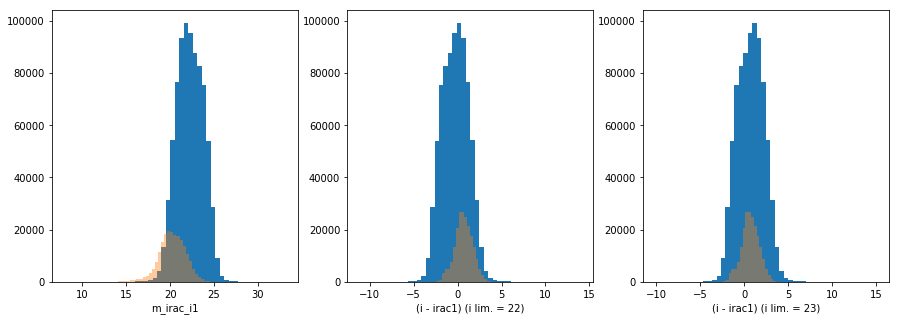

In [80]:
plt.rcParams["figure.figsize"] = (15,5)
subplot(1,3,1)
hist(combined["m_irac_i1"][combined_wise], bins=50)
hist(combined["m_irac_i1"][combined_matched], bins=50, alpha=0.4)
xlabel("m_irac_i1")
subplot(1,3,2)
hist((22 - combined["m_irac_i1"])[combined_wise], bins=50)
hist((combined["m_gpc1_i"] - combined["m_irac_i1"])[combined_matched], bins=50, alpha=0.4)
xlabel("(i - irac1) (i lim. = 22)")
subplot(1,3,3)
hist((23 - combined["m_irac_i1"])[combined_wise], bins=50)
hist((combined["m_gpc1_i"] - combined["m_irac_i1"])[combined_matched], bins=50, alpha=0.4)
xlabel("(i - irac1) (i lim. = 23)");

## Maximum Likelihood 1st

### i-band preparation

In [81]:
bandwidth_i = 0.5

In [82]:
catalogue_i = combined[combined_i]

In [83]:
bin_list_i = np.arange(16., 28., 0.5) # Bins of 0.5

In [84]:
center_i = get_center(bin_list_i)

In [86]:
n_m_i1 = get_n_m(catalogue_i["m_gpc1_i"], bin_list_i, field.area)

In [87]:
n_m_i = get_n_m_kde(catalogue_i["m_gpc1_i"], center_i, field.area, bandwidth=bandwidth_i)

In [88]:
n_m_i_cs = np.cumsum(n_m_i)

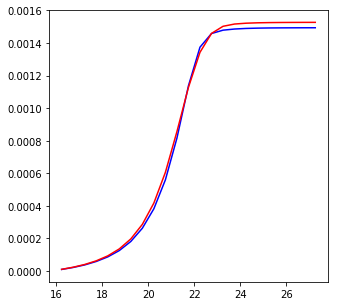

In [89]:
plt.rcParams["figure.figsize"] = (5,5)
plot(center_i, n_m_i1,color='blue');
plot(center_i, n_m_i_cs,color='red');

In [90]:
q_m_i1 = estimate_q_m(catalogue_i["m_gpc1_i"], 
                      bin_list_i, 
                      n_m_i1, 
                      coords_lofar, 
                      coords_combined[combined_i], 
                      radius=5)

In [91]:
q_m_i = estimate_q_m_kde(catalogue_i["m_gpc1_i"], 
                      center_i, 
                      n_m_i, 
                      coords_lofar, 
                      coords_combined[combined_i], 
                      radius=5, 
                      bandwidth=bandwidth_i)

In [92]:
q_m_i_cs = np.cumsum(q_m_i)

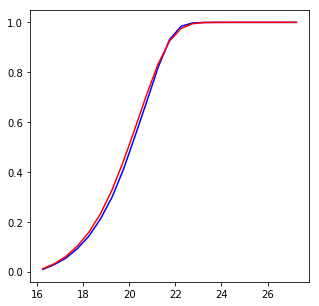

In [93]:
plt.rcParams["figure.figsize"] = (5,5)
plot(center_i, q_m_i1,color='blue');
plot(center_i, q_m_i_cs,color='red');

In [94]:
n_m_i1

array([9.60598236e-06, 2.18184878e-05, 3.73827465e-05, 5.85415807e-05,
       8.65893377e-05, 1.25501767e-04, 1.81333420e-04, 2.62442284e-04,
       3.82114140e-04, 5.59671489e-04, 8.15542198e-04, 1.13700387e-03,
       1.37400492e-03, 1.45777735e-03, 1.47843699e-03, 1.48549350e-03,
       1.48910199e-03, 1.49093832e-03, 1.49204012e-03, 1.49260350e-03,
       1.49292441e-03, 1.49318471e-03, 1.49331664e-03])

In [95]:
q_m_i1

array([0.00938351, 0.02885628, 0.05464779, 0.09275005, 0.1428321 ,
       0.21129851, 0.2980989 , 0.41073602, 0.54330553, 0.67959998,
       0.81869324, 0.9309044 , 0.98419032, 0.99767431, 0.99943316,
       0.99971919, 0.99989054, 0.9999377 , 0.9999377 , 0.99995783,
       0.99996435, 0.99997635, 1.        ])

In [96]:
mask = combined['m_gpc1_i']<18
len(combined[mask])

/Users/im281/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


25647

In [97]:
field.area

280450233.8265755

(0, 2000)

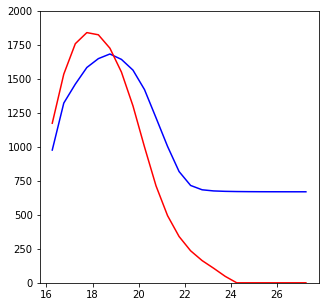

In [98]:
plt.rcParams["figure.figsize"] = (5,5)
plot(center_i, q_m_i1/n_m_i1,color='blue');
plot(center_i, q_m_i/n_m_i,color='red');
plt.ylim(0,2000)

### W1-band preparation

In [99]:
bandwidth_w1 = 0.5

In [100]:
catalogue_w1 = combined[combined_w1]

In [101]:
bin_list_w1 = np.arange(12., 28., 0.5) # Bins of 0.5

In [102]:
center_w1 = get_center(bin_list_w1)

In [103]:
n_m_w11 = get_n_m(catalogue_w1["m_irac_i1"], bin_list_w1, field.area)

In [104]:
n_m_w1 = get_n_m_kde(catalogue_w1["m_irac_i1"], center_w1, field.area, bandwidth=bandwidth_w1)

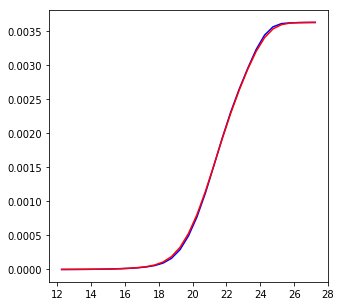

In [105]:
plt.rcParams["figure.figsize"] = (5,5)
plot(center_w1, n_m_w11,color='blue');
plot(center_w1, np.cumsum(n_m_w1),color='red');

In [106]:
q_m_w11 = estimate_q_m(catalogue_w1["m_irac_i1"], 
                      bin_list_w1, 
                      n_m_w11, coords_lofar, 
                      coords_combined[combined_w1], 
                      radius=5)

In [107]:
q_m_w1 = estimate_q_m_kde(catalogue_w1["m_irac_i1"], 
                      center_w1, 
                      n_m_w1, coords_lofar, 
                      coords_combined[combined_w1], 
                      radius=5, 
                      bandwidth=bandwidth_w1)

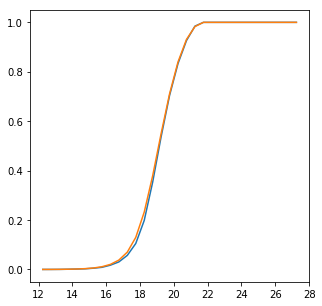

In [108]:
plot(center_w1, q_m_w11);
plot(center_w1, np.cumsum(q_m_w1));

(0, 2300)

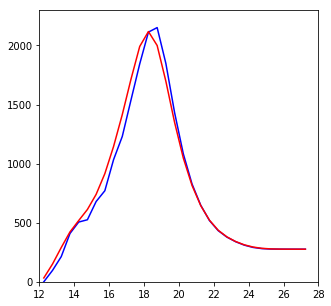

In [113]:
plot(center_w1, q_m_w11/n_m_w11,color='blue');
plot(center_w1, np.cumsum(q_m_w1)/np.cumsum(n_m_w1),color='red');
plt.xlim(12,28)
plt.ylim(0,2300)

### $Q_0$ and likelihood estimators

In [115]:
# Old
Q0_i = 0.545
Q0_w1 = 0.77
# Better Q0
Q0_i = 0.503
Q0_w1 = 0.699
# Cleaned v0.7 Q0
Q0_i = 0.518
Q0_w1 = 0.713
# Cleaned v0.8 Q0 - 4 arcsecs
Q0_i = 0.512
Q0_w1 = 0.700

In [116]:
# find the radius used for the crossmatching that gives the optimal value of Q0
mask = ~np.isnan(combined['m_gpc1_i'])
Q0_i,search_rad_r = Q0_calc(lofar,combined[mask],'RA','DEC','ra','dec','m_gpc1_i',min(lofar['RA']),max(lofar['RA']),min(lofar['DEC']),max(lofar['DEC']),0.1,8,30,moc=MHz150_MOC)

field area is defined by a MOC
filtering in a MOC
filtering in a MOC
[    0     1     2 ... 27873 27874 27874]
18569
starting to find Q0. This will take a while
finding Q0 with radius = 0.1 arcseconds
number of random sources with no matches: 18567
number of real sources with no matches: 18279
number of random sources with no matches: 18569
number of real sources with no matches: 18279
number of random sources with no matches: 18567
number of real sources with no matches: 18279
number of random sources with no matches: 18567
number of real sources with no matches: 18279
number of random sources with no matches: 18568
number of real sources with no matches: 18279
number of random sources with no matches: 18567
number of real sources with no matches: 18279
number of random sources with no matches: 18567
number of real sources with no matches: 18279
number of random sources with no matches: 18569
number of real sources with no matches: 18279
number of random sources with no matches: 18569

number of random sources with no matches: 18130
number of real sources with no matches: 10359
number of random sources with no matches: 18162
number of real sources with no matches: 10359
number of random sources with no matches: 18129
number of real sources with no matches: 10359
number of random sources with no matches: 18124
number of real sources with no matches: 10359
number of random sources with no matches: 18075
number of real sources with no matches: 10359
number of random sources with no matches: 18123
number of real sources with no matches: 10359
number of random sources with no matches: 18091
number of real sources with no matches: 10359
number of random sources with no matches: 18113
number of real sources with no matches: 10359
number of random sources with no matches: 18078
number of real sources with no matches: 10359
finding Q0 with radius = 2.5517241379310343 arcseconds
number of random sources with no matches: 17989
number of real sources with no matches: 10183
numbe

number of random sources with no matches: 16903
number of real sources with no matches: 9278
number of random sources with no matches: 16842
number of real sources with no matches: 9278
number of random sources with no matches: 16790
number of real sources with no matches: 9278
number of random sources with no matches: 16862
number of real sources with no matches: 9278
number of random sources with no matches: 16922
number of real sources with no matches: 9278
finding Q0 with radius = 4.73103448275862 arcseconds
number of random sources with no matches: 16596
number of real sources with no matches: 9161
number of random sources with no matches: 16672
number of real sources with no matches: 9161
number of random sources with no matches: 16651
number of real sources with no matches: 9161
number of random sources with no matches: 16738
number of real sources with no matches: 9161
number of random sources with no matches: 16664
number of real sources with no matches: 9161
number of random 

number of random sources with no matches: 15095
number of real sources with no matches: 8165
finding Q0 with radius = 6.910344827586206 arcseconds
number of random sources with no matches: 14875
number of real sources with no matches: 8022
number of random sources with no matches: 14730
number of real sources with no matches: 8022
number of random sources with no matches: 14822
number of real sources with no matches: 8022
number of random sources with no matches: 14765
number of real sources with no matches: 8022
number of random sources with no matches: 14794
number of real sources with no matches: 8022
number of random sources with no matches: 14738
number of real sources with no matches: 8022
number of random sources with no matches: 14720
number of real sources with no matches: 8022
number of random sources with no matches: 14756
number of real sources with no matches: 8022
number of random sources with no matches: 14803
number of real sources with no matches: 8022
number of random

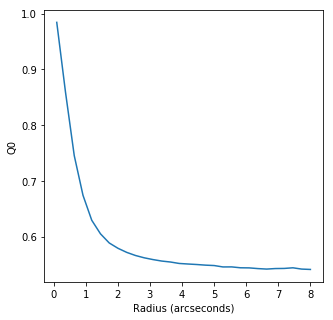

In [117]:
x = search_rad_r
y = 1 - np.array(Q0_i)
plt.plot(x,y)
plt.xlabel('Radius (arcseconds)')
plt.ylabel('Q0')
plt.show()

In [118]:
Q0 = max(Q0_i)
search_rad_i = search_rad_r[Q0_i == Q0][0]
#Q0 = popt[0]
#search_rad = 6.9103

print('Q0 = {}'.format(Q0))
print('search radius = {}'.format(search_rad_i))
Q0_i = Q0

Q0 = 0.4587911440011162
search radius = 8.0


In [119]:
# find the radius used for the crossmatching that gives the optimal value of Q0
mask = ~np.isnan(combined['m_irac_i1'])
Q0_w1,search_rad_r = Q0_calc(lofar,combined[mask],'RA','DEC','ra','dec','m_irac_i1',min(lofar['RA']),max(lofar['RA']),min(lofar['DEC']),max(lofar['DEC']),0.1,8,30,moc=MHz150_MOC)

field area is defined by a MOC
filtering in a MOC
filtering in a MOC
[    0     1     2 ... 27873 27874 27874]
18569
starting to find Q0. This will take a while
finding Q0 with radius = 0.1 arcseconds
number of random sources with no matches: 18565
number of real sources with no matches: 18188
number of random sources with no matches: 18565
number of real sources with no matches: 18188
number of random sources with no matches: 18566
number of real sources with no matches: 18188
number of random sources with no matches: 18565
number of real sources with no matches: 18188
number of random sources with no matches: 18566
number of real sources with no matches: 18188
number of random sources with no matches: 18568
number of real sources with no matches: 18188
number of random sources with no matches: 18568
number of real sources with no matches: 18188
number of random sources with no matches: 18564
number of real sources with no matches: 18188
number of random sources with no matches: 18569

number of random sources with no matches: 17512
number of real sources with no matches: 7601
number of random sources with no matches: 17514
number of real sources with no matches: 7601
number of random sources with no matches: 17465
number of real sources with no matches: 7601
number of random sources with no matches: 17468
number of real sources with no matches: 7601
number of random sources with no matches: 17483
number of real sources with no matches: 7601
number of random sources with no matches: 17486
number of real sources with no matches: 7601
number of random sources with no matches: 17517
number of real sources with no matches: 7601
number of random sources with no matches: 17509
number of real sources with no matches: 7601
number of random sources with no matches: 17514
number of real sources with no matches: 7601
finding Q0 with radius = 2.5517241379310343 arcseconds
number of random sources with no matches: 17249
number of real sources with no matches: 7511
number of rando

number of random sources with no matches: 15058
number of real sources with no matches: 7215
number of random sources with no matches: 15045
number of real sources with no matches: 7215
number of random sources with no matches: 15010
number of real sources with no matches: 7215
number of random sources with no matches: 15034
number of real sources with no matches: 7215
number of random sources with no matches: 15079
number of real sources with no matches: 7215
finding Q0 with radius = 4.73103448275862 arcseconds
number of random sources with no matches: 14809
number of real sources with no matches: 7198
number of random sources with no matches: 14723
number of real sources with no matches: 7198
number of random sources with no matches: 14748
number of real sources with no matches: 7198
number of random sources with no matches: 14725
number of real sources with no matches: 7198
number of random sources with no matches: 14761
number of real sources with no matches: 7198
number of random 

number of real sources with no matches: 7060
number of random sources with no matches: 12753
number of real sources with no matches: 7060
finding Q0 with radius = 6.910344827586206 arcseconds
number of random sources with no matches: 12421
number of real sources with no matches: 7048
number of random sources with no matches: 12476
number of real sources with no matches: 7048
number of random sources with no matches: 12502
number of real sources with no matches: 7048
number of random sources with no matches: 12395
number of real sources with no matches: 7048
number of random sources with no matches: 12561
number of real sources with no matches: 7048
number of random sources with no matches: 12424
number of real sources with no matches: 7048
number of random sources with no matches: 12472
number of real sources with no matches: 7048
number of random sources with no matches: 12311
number of real sources with no matches: 7048
number of random sources with no matches: 12445
number of real s

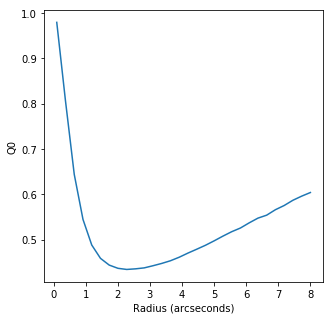

In [120]:
x = search_rad_r
y = 1 - np.array(Q0_w1)
plt.plot(x,y)
plt.xlabel('Radius (arcseconds)')
plt.ylabel('Q0')
plt.show()

In [121]:
Q0 = max(Q0_w1)
search_rad_w1 = search_rad_r[Q0_w1 == Q0][0]
#Q0 = popt[0]
#search_rad = 6.9103

print('Q0 = {}'.format(Q0))
print('search radius = {}'.format(search_rad_w1))
Q0_w1 = Q0

Q0 = 0.565505107053363
search radius = 2.279310344827586


In [122]:
likelihood_ratio_i = SingleMLEstimator(Q0_i, n_m_i, q_m_i, center_i)

In [123]:
likelihood_ratio_w1 = SingleMLEstimator(Q0_w1, n_m_w1, q_m_w1, center_w1)

We will get the number of CPUs to use in parallel in the computations

In [124]:
import multiprocessing

In [125]:
n_cpus_total = multiprocessing.cpu_count()

In [126]:
n_cpus = max(1, n_cpus_total-1)

### i-band match

In [151]:
radius = 15

In [152]:
idx_lofar, idx_i, d2d, d3d = search_around_sky(
    coords_lofar, coords_combined[combined_i], radius*u.arcsec)

In [153]:
idx_lofar_unique = np.unique(idx_lofar)

In [154]:
len(idx_lofar_unique)

22814

In [155]:
lofar["lr_i"] = np.nan                   # Likelihood ratio
lofar["lr_dist_i"] = np.nan              # Distance to the selected source
lofar["lr_index_i"] = np.nan             # Index of the PanSTARRS source in combined
lofar["lr_reliability_i"] = np.nan
lofar["helpid_i"] = ''

In [156]:
total_sources = len(idx_lofar_unique)
combined_aux_index = np.arange(len(combined))

In [157]:
def ml(i):

    idx_0 = idx_i[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    i_mag = catalogue_i["m_gpc1_i"][idx_0]
    
    lofar_ra = lofar[i]["RA"]
    lofar_dec = lofar[i]["DEC"]
    lofar_pa = lofar[i]["PA"]
    lofar_maj_err = lofar[i]["E_Maj"]
    lofar_min_err = lofar[i]["E_Min"]
    c_ra = catalogue_i["ra"][idx_0]
    c_dec = catalogue_i["dec"][idx_0]
    c_ra_err = 1.0
    c_dec_err = 1.0
    
    sigma, sigma_maj, sigma_min = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)
    
    lr_0 = likelihood_ratio_i(i_mag, d2d_0.arcsec, sigma)
    if len(lr_0) == 0:
        result = [np.nan,np.nan,np.nan,np.nan,np.nan]
        return result
    chosen_index = np.argmax(lr_0)
    lr_sum = np.sum(lr_0)
    rel = lr_0/(lr_sum + (1-Q0_i))
    helpid = catalogue_i['help_id'][idx_0][0]
    result = [combined_aux_index[combined_i][idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index],
              rel[chosen_index],
              helpid]                                  # LR
    

    return(result)
    #return (result,rel[chosen_index],helpid)

In [158]:
res = parallel_process(idx_lofar_unique, ml, n_jobs=n_cpus)

100%|██████████| 22.8k/22.8k [02:55<00:00, 130it/s] 
100%|██████████| 22811/22811 [00:00<00:00, 231072.52it/s]


In [159]:
len(res)

22814

In [160]:
(lofar["lr_index_i"][idx_lofar_unique], 
 lofar["lr_dist_i"][idx_lofar_unique], 
 lofar["lr_i"][idx_lofar_unique],
 lofar["lr_reliability_i"][idx_lofar_unique],
 lofar["helpid_i"][idx_lofar_unique]) = list(map(list, zip(*res)))

/Users/im281/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: StringTruncateWarning: truncated right side string(s) longer than 1 character(s) during assignment


#### Threshold and selection for i-band

In [161]:
lofar["lr_i"][np.isnan(lofar["lr_i"])] = 0

In [162]:
mask = ~np.isnan(lofar['lr_dist_i'])
threshold_i = np.percentile(lofar["lr_i"][mask], 100*(1 - Q0_i))

In [163]:
threshold_i #4.8 before

11.49102607563433

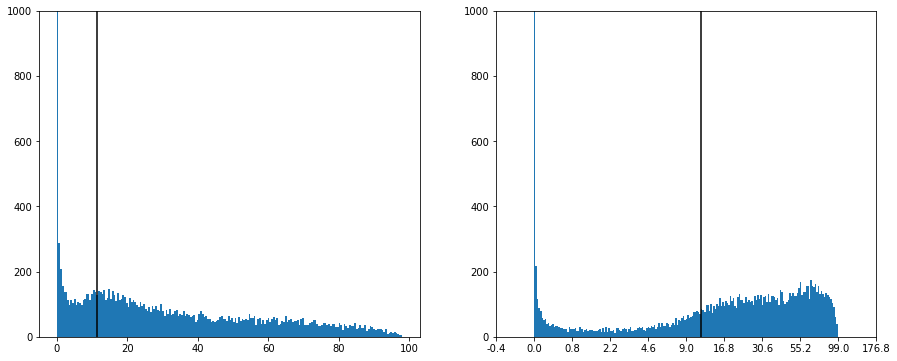

In [164]:
plt.rcParams["figure.figsize"] = (15,6)
subplot(1,2,1)
hist(lofar[lofar["lr_i"] != 0]["lr_i"], bins=200)
vlines([threshold_i], 0, 1000)
ylim([0,1000])
subplot(1,2,2)
hist(np.log10(lofar[lofar["lr_i"] != 0]["lr_i"]+1), bins=200)
vlines(np.log10(threshold_i+1), 0, 1000)
ticks, _ = xticks()
xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
ylim([0,1000]);

In [165]:
lofar["lr_index_sel_i"] = lofar["lr_index_i"]
lofar["lr_index_sel_i"][lofar["lr_i"] < threshold_i] = np.nan

In [166]:
np.sum(lofar['lr_i']>threshold_i)

10467

/Users/im281/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/im281/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


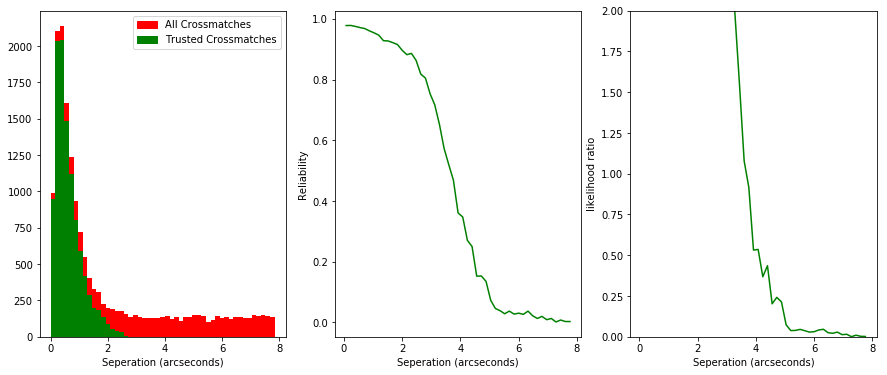

In [167]:
plt.rcParams["figure.figsize"] = (15,6)
bins = np.arange(0,search_rad_i,search_rad_i/50)
plt.subplot(1,3,1)
mask = ~np.isnan(lofar['lr_dist_i'])
plt.hist(lofar['lr_dist_i'][mask],bins=bins,color='red')
mask = (lofar['lr_i'] > threshold_i) & (~np.isnan(lofar['lr_dist_i']))
plt.hist(lofar['lr_dist_i'][mask],bins=bins,color='green')
plt.xlabel('Seperation (arcseconds)')
green_patch = mpatches.Patch(color='green',label='Trusted Crossmatches')
red_patch = mpatches.Patch(color='red',label='All Crossmatches')
plt.legend(handles=[red_patch,green_patch])

plt.subplot(1,3,2)
reliability_r = []
mask1 = (~np.isnan(lofar['lr_dist_i']))
for n in range(len(bins)-1):
    mask = (lofar['lr_dist_i'] > bins[n]) & (lofar['lr_dist_i'] < bins[n+1])
    mask = mask
    rel_temp = lofar['lr_reliability_i'][mask]
    reliability_r.append(np.mean(rel_temp))
rad_cent = get_center(bins)
plt.plot(rad_cent,reliability_r,color='green')
plt.xlabel('Seperation (arcseconds)')
plt.ylabel('Reliability')

plt.subplot(1,3,3)
lrt_r = []
mask1 = (~np.isnan(lofar['lr_dist_i']))
for n in range(len(bins)-1):
    mask = (lofar['lr_dist_i'] > bins[n]) & (lofar['lr_dist_i'] < bins[n+1])
    #mask = mask[mask1]
    rel_temp = lofar['lr_i'][mask]
    lrt_r.append(np.mean(rel_temp))
rad_cent = get_center(bins)
plt.plot(rad_cent,lrt_r,color='green')
plt.xlabel('Seperation (arcseconds)')
plt.ylabel('likelihood ratio')
plt.ylim(0,2)

plt.show()

### W1-band match

In [168]:
idx_lofar, idx_i, d2d, d3d = search_around_sky(
    coords_lofar, coords_combined[combined_w1], radius*u.arcsec)

In [169]:
idx_lofar_unique = np.unique(idx_lofar)

In [170]:
len(idx_lofar_unique)

18514

In [171]:
lofar["lr_w1"] = np.nan                   # Likelihood ratio
lofar["lr_dist_w1"] = np.nan              # Distance to the selected source
lofar["lr_index_w1"] = np.nan             # Index of the PanSTARRS source in combined
lofar["lr_reliability_w1"] = np.nan
lofar["helpid_w1"] = ''

In [172]:
len(catalogue_i)

428089

In [173]:
def ml_w1(i):
    
    idx_0 = idx_i[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    i_mag = catalogue_w1["m_irac_i1"][idx_0]
    
    lofar_ra = lofar[i]["RA"]
    lofar_dec = lofar[i]["DEC"]
    lofar_pa = lofar[i]["PA"]
    lofar_maj_err = lofar[i]["E_Maj"]
    lofar_min_err = lofar[i]["E_Min"]
    c_ra = catalogue_w1["ra"][idx_0]
    c_dec = catalogue_w1["dec"][idx_0]
    c_ra_err = 1.0
    c_dec_err = 1.0
    
    sigma, sigma_maj, sigma_min = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)
    
    lr_0 = likelihood_ratio_w1(i_mag, d2d_0.arcsec, sigma)

    if len(lr_0) == 0:

        result = [np.nan,np.nan,np.nan,np.nan,np.nan]
        return result
    chosen_index = np.argmax(lr_0)
    lr_sum = np.sum(lr_0)
    rel = lr_0/(lr_sum + (1-Q0_i))
    helpid = catalogue_w1['help_id'][idx_0][0]
    result = [combined_aux_index[combined_w1][idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index],
              rel[chosen_index],
              helpid]                                  # LR
    

    return(result)
    #return (result,rel[chosen_index],helpid)

In [174]:
res = parallel_process(idx_lofar_unique, ml_w1, n_jobs=n_cpus)

100%|██████████| 18.5k/18.5k [03:26<00:00, 89.5it/s]
100%|██████████| 18511/18511 [00:00<00:00, 155343.35it/s]


In [175]:
len(res)
np.sum(np.isnan(lofar['lr_dist_w1']))

27875

In [176]:
(lofar["lr_index_w1"][idx_lofar_unique], 
 lofar["lr_dist_w1"][idx_lofar_unique], 
 lofar["lr_w1"][idx_lofar_unique],
 lofar["lr_reliability_w1"][idx_lofar_unique],
 lofar["helpid_w1"][idx_lofar_unique]) = list(map(list, zip(*res)))

/Users/im281/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: StringTruncateWarning: truncated right side string(s) longer than 1 character(s) during assignment


#### Threshold and selection for W1 band

In [177]:
lofar["lr_w1"][np.isnan(lofar["lr_w1"])] = 0

In [178]:
mask = ~np.isnan(lofar['lr_dist_w1'])
threshold_w1 = np.percentile(lofar["lr_w1"][mask], 100*(1 - Q0_w1))

In [179]:
threshold_w1 # 0.695 before

30.18218160673725

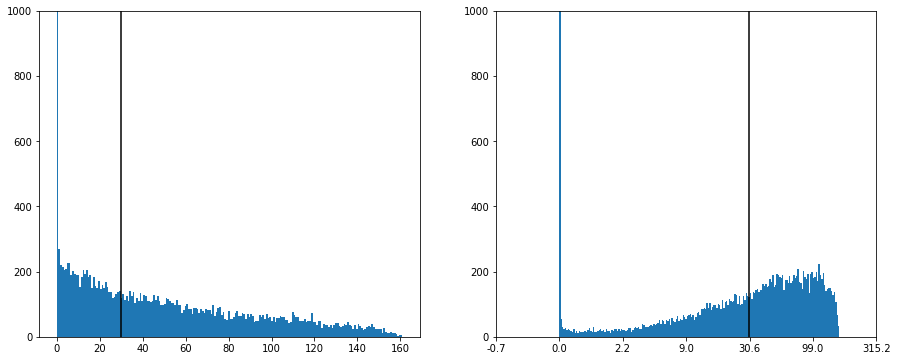

In [180]:
plt.rcParams["figure.figsize"] = (15,6)
subplot(1,2,1)
hist(lofar[lofar["lr_w1"] != 0]["lr_w1"], bins=200)
vlines([threshold_w1], 0, 1000)
ylim([0,1000])
subplot(1,2,2)
hist(np.log10(lofar[lofar["lr_w1"] != 0]["lr_w1"]+1), bins=200)
vlines(np.log10(threshold_w1+1), 0, 1000)
ticks, _ = xticks()
xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
ylim([0,1000]);

In [181]:
lofar["lr_index_sel_w1"] = lofar["lr_index_w1"]
lofar["lr_index_sel_w1"][lofar["lr_w1"] < threshold_w1] = np.nan

In [182]:
len((~np.isnan(lofar['lr_dist_w1'])))

27875

/Users/im281/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/im281/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


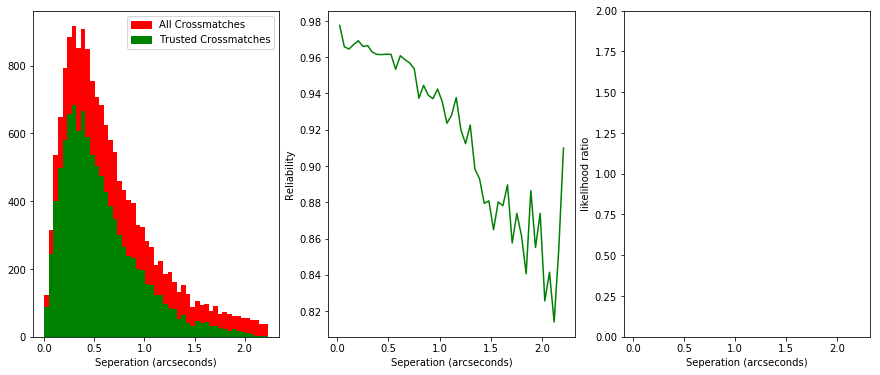

In [183]:
plt.rcParams["figure.figsize"] = (15,6)
bins = np.arange(0,search_rad_w1,search_rad_w1/50)
plt.subplot(1,3,1)
mask = ~np.isnan(lofar['lr_dist_w1'])
plt.hist(lofar['lr_dist_w1'][mask],bins=bins,color='red')
mask = (lofar['lr_w1'] > threshold_w1) & (~np.isnan(lofar['lr_dist_w1']))
plt.hist(lofar['lr_dist_w1'][mask],bins=bins,color='green')
plt.xlabel('Seperation (arcseconds)')
green_patch = mpatches.Patch(color='green',label='Trusted Crossmatches')
red_patch = mpatches.Patch(color='red',label='All Crossmatches')
plt.legend(handles=[red_patch,green_patch])

plt.subplot(1,3,2)
reliability_r = []
mask1 = (~np.isnan(lofar['lr_dist_w1']))
for n in range(len(bins)-1):
    mask = (lofar['lr_dist_w1'] > bins[n]) & (lofar['lr_dist_w1'] < bins[n+1])
    mask = mask
    rel_temp = lofar['lr_reliability_w1'][mask]
    reliability_r.append(np.mean(rel_temp))
rad_cent = get_center(bins)
plt.plot(rad_cent,reliability_r,color='green')
plt.xlabel('Seperation (arcseconds)')
plt.ylabel('Reliability')

plt.subplot(1,3,3)
lrt_r = []
mask1 = (~np.isnan(lofar['lr_dist_w1']))
for n in range(len(bins)-1):
    mask = (lofar['lr_dist_w1'] > bins[n]) & (lofar['lr_dist_w1'] < bins[n+1])
    #mask = mask[mask1]
    rel_temp = lofar['lr_w1'][mask]
    lrt_r.append(np.mean(rel_temp))
rad_cent = get_center(bins)
plt.plot(rad_cent,lrt_r,color='green')
plt.xlabel('Seperation (arcseconds)')
plt.ylabel('likelihood ratio')
plt.ylim(0,2)

plt.show()

### Final selection of the match

We combine the ML matching done in i-band and W1-band. All the galaxies were the LR is above the selection ratio for the respective band are finally selected.

In [185]:
len(lofar)

27875

In [186]:
np.sum(np.isnan(lofar['lr_index_sel_i']))

17408

In [187]:
# lr_i_and_w1 = (lofar["lr_i"] != 0) & (lofar["lr_w1"] != 0)
# lr_only_i = (lofar["lr_i"] != 0) & (lofar["lr_w1"] == 0)
# lr_only_w1 = (lofar["lr_i"] == 0) & (lofar["lr_w1"] != 0)
# lr_no_match = (lofar["lr_i"] == 0) & (lofar["lr_w1"] == 0)
lr_i_and_w1 = ~np.isnan(lofar["lr_index_sel_i"]) & ~np.isnan(lofar["lr_index_sel_w1"])
lr_only_i = ~np.isnan(lofar["lr_index_sel_i"]) & np.isnan(lofar["lr_index_sel_w1"])
lr_only_w1 = np.isnan(lofar["lr_index_sel_i"]) & ~np.isnan(lofar["lr_index_sel_w1"])
lr_no_match = np.isnan(lofar["lr_index_sel_i"]) & np.isnan(lofar["lr_index_sel_w1"])

In [188]:
print(np.sum(lr_i_and_w1))
print(np.sum(lr_only_i))
print(np.sum(lr_only_w1))
print(np.sum(lr_no_match))

6645
3822
3825
13583


In [189]:
lofar["lr_index_1"] = np.nan
lofar["lr_dist_1"] = np.nan
lofar["lr_1"] = np.nan
lofar["lr_type_1"] = 0

In [190]:
# Only i matches
lofar["lr_1"][lr_only_i] = lofar["lr_i"][lr_only_i]
lofar["lr_index_1"][lr_only_i] = lofar["lr_index_i"][lr_only_i]
lofar["lr_dist_1"][lr_only_i] = lofar["lr_dist_i"][lr_only_i]
lofar["lr_type_1"][lr_only_i] = 1

# Only w1 matches
lofar["lr_1"][lr_only_w1] = lofar["lr_w1"][lr_only_w1]
lofar["lr_index_1"][lr_only_w1] = lofar["lr_index_w1"][lr_only_w1]
lofar["lr_dist_1"][lr_only_w1] = lofar["lr_dist_w1"][lr_only_w1]
lofar["lr_type_1"][lr_only_w1] = 2

# Both matches
lofar["lr_1"][lr_i_and_w1] = np.max([lofar["lr_i"][lr_i_and_w1], lofar["lr_w1"][lr_i_and_w1]], axis=0)
lofar["lr_type_1"][lr_i_and_w1] = np.argmax([lofar["lr_i"][lr_i_and_w1], lofar["lr_w1"][lr_i_and_w1]], axis=0) + 1

c1 = (lofar["lr_type_1"] == 1)
c2 = (lofar["lr_type_1"] == 2)
lofar["lr_index_1"][lr_i_and_w1 & c1] = lofar["lr_index_i"][lr_i_and_w1 & c1]
lofar["lr_index_1"][lr_i_and_w1 & c2] = lofar["lr_index_w1"][lr_i_and_w1 & c2]
lofar["lr_dist_1"][lr_i_and_w1 & c1] = lofar["lr_dist_i"][lr_i_and_w1 & c1]
lofar["lr_dist_1"][lr_i_and_w1 & c2] = lofar["lr_dist_w1"][lr_i_and_w1 & c2]

Summary of the number of sources matches of each type

In [191]:
print("match    sel-i: ", np.sum(lofar["lr_type_1"][lr_i_and_w1] == 1))
print("match   sel-W1: ", np.sum(lofar["lr_type_1"][lr_i_and_w1] == 2))
print("match     both: ", np.sum(lofar["lr_type_1"][lr_i_and_w1] == 1) + 
                          np.sum(lofar["lr_type_1"][lr_i_and_w1] == 2))
print("match   i-only: ", np.sum(lofar["lr_type_1"] == 1) - np.sum(lofar["lr_type_1"][lr_i_and_w1] == 1))
print("match  W1-only: ", np.sum(lofar["lr_type_1"] == 2) - np.sum(lofar["lr_type_1"][lr_i_and_w1] == 2))
print("match      all: ", np.sum(lofar["lr_type_1"] == 1) + 
                          np.sum(lofar["lr_type_1"] == 2))
print("         Total: ", len(lofar))

match    sel-i:  68
match   sel-W1:  6577
match     both:  6645
match   i-only:  3822
match  W1-only:  3825
match      all:  14292
         Total:  27875


The number of sources for which the match in i-band and W1-band are above the threshold but gives a different match to the combined catalogue.

In [192]:
print(np.sum(lofar["lr_index_i"][lr_i_and_w1] != lofar["lr_index_w1"][lr_i_and_w1]))

275


#### Duplicated sources

This is the nymber of sources of the combined catalogue that are combined to multiple LOFAR sources. In the case of the catalogue of Gaussians the number can be very high.

In [193]:
values, counts = np.unique(lofar[lofar["lr_type_1"] != 0]["lr_index_1"], return_counts=True)

In [194]:
len(values[counts > 1])

1

In [195]:
n_dup, n_sour = np.unique(counts[counts > 1], return_counts=True)

/Users/im281/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3239: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


Text(0,0.5,'Number of sources in the category')

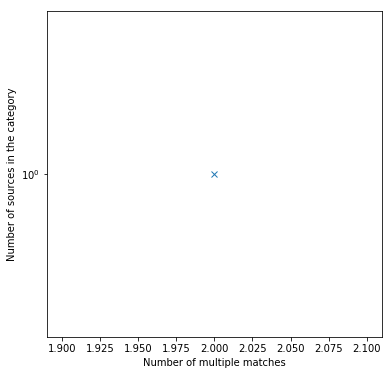

In [196]:
plt.rcParams["figure.figsize"] = (6,6)
semilogy(n_dup, n_sour, marker="x")
xlabel("Number of multiple matches")
ylabel("Number of sources in the category")

### Save intermediate data

if save_intermediate:
    pickle.dump([bin_list_i, center_i, Q0_i, n_m_i1, q_m_i1], 
                open("{}/lofar_params_cumsum_1i.pckl".format(idp), 'wb'))
    pickle.dump([bin_list_w1, center_w1, Q0_w1, n_m_w11, q_m_w11], 
                open("{}/lofar_params_cumsum_1w1.pckl".format(idp), 'wb'))
    pickle.dump([bin_list_i, center_i, Q0_i, n_m_i, q_m_i], 
                open("{}/lofar_params_1i.pckl".format(idp), 'wb'))
    pickle.dump([bin_list_w1, center_w1, Q0_w1, n_m_w1, q_m_w1], 
                open("{}/lofar_params_1w1.pckl".format(idp), 'wb'))
    lofar.write("{}/lofar_m1.fits".format(idp), format="fits")

## Second iteration using colour

From now on we will take into account the effect of the colour. The sample was distributed in several categories according to the colour of the source and this is considered here.

### Rusable parameters for all the iterations

These parameters are derived from the underlying population and will not change.

First we compute the number of galaxies in each bin for the combined catalogue

In [197]:
bin_list = [bin_list_w1 if i == 0 else bin_list_i for i in range(len(colour_bin_def))]
centers = [center_w1 if i == 0 else center_i for i in range(len(colour_bin_def))]

In [198]:
numbers_combined_bins = np.array([np.sum(a["condition"]) for a in colour_bin_def])

In [199]:
numbers_combined_bins

array([812488, 223884,  45689,  40130,  40736,  17939,  15844,  13291,
        10625,   7823,   5276,   3231,   1799,   1385,    299,    138])

Get the colour category and magnitudes for the matched LOFAR sources

In [200]:
bandwidth_colour = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

In [202]:
n_m = []

# W1 only sources
n_m.append(get_n_m_kde(combined["m_irac_i1"][combined["category"] == 0], 
                       centers[0], field.area, bandwidth=bandwidth_colour[0]))

# Rest of the sources
for i in range(1, len(colour_bin_def)):
    n_m.append(get_n_m_kde(combined["m_gpc1_i"][combined["category"] == i], 
                           centers[i], field.area, bandwidth=bandwidth_colour[i]))

In [203]:
n_m_old = []

# W1 only sources
n_m_old.append(get_n_m(combined["m_irac_i1"][combined["category"] == 0], bin_list_w1, field.area))

# Rest of the sources
for i in range(1, len(colour_bin_def)):
    n_m_old.append(get_n_m(combined["m_gpc1_i"][combined["category"] == i], bin_list_i, field.area))

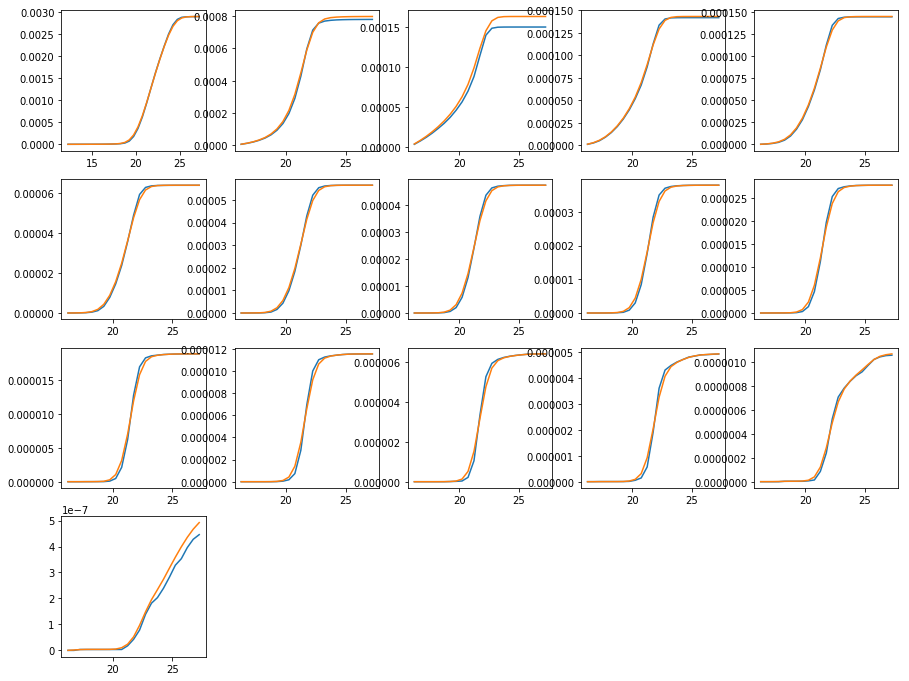

In [204]:
plt.rcParams["figure.figsize"] = (15,15)
for i, n_m_k in enumerate(n_m):
    subplot(5,5,i+1)
    plot(centers[i], n_m_old[i])
    plot(centers[i], np.cumsum(n_m_k))

### Parameters of the matched sample

The parameters derived from the matched LOFAR galaxies: $q_0$, q(m) and the number of sources per category.

The columns "category", "W1mag" and "i" will contain the properties of the matched galaxies and will be updated in each iteration to save space.

In [205]:
lofar["category"] = np.nan
lofar["m_irac_i1"] = np.nan
lofar["m_gpc1_i"] = np.nan

In [206]:
c = ~np.isnan(lofar["lr_index_1"])
indices = lofar["lr_index_1"][c].astype(int)
lofar["category"][c] = combined[indices]["category"]
lofar["m_irac_i1"][c] = combined[indices]["m_irac_i1"]
lofar["m_gpc1_i"][c] = combined[indices]["m_gpc1_i"]

The next parameter represent the number of matched LOFAR sources in each colour category.

In [207]:
numbers_lofar_combined_bins = np.array([np.sum(lofar["category"] == c) 
                                        for c in range(len(numbers_combined_bins))])

In [208]:
numbers_lofar_combined_bins

array([3653, 3504,  136,  879, 1323,  713,  726,  666,  625,  599,  518,
        421,  229,  218,   67,   15])

The $Q_0$ for each category are obtained by dividing the number of sources in the category by the total number of sources in the sample.

In [209]:
Q_0_colour = numbers_lofar_combined_bins/len(lofar) ### Q_0

In [210]:
q0_total = np.sum(Q_0_colour)

In [211]:
q0_total

0.5127174887892376

The q(m) is not estimated with the method of Fleuren et al. but with the most updated distributions and numbers for the matches.

In [213]:
q_m_old = []
radius = 15. 

# W1 only sources
q_m_old.append(get_q_m(lofar["m_irac_i1"][lofar["category"] == 0], 
                   bin_list_w1, 
                   numbers_lofar_combined_bins[0], 
                   n_m_old[0], 
                   field.area, 
                   radius=radius))

# Rest of the sources
for i in range(1, len(numbers_lofar_combined_bins)):
    q_m_old.append(get_q_m(lofar["m_gpc1_i"][lofar["category"] == i], 
                   bin_list_i, 
                   numbers_lofar_combined_bins[i], 
                   n_m_old[i], 
                   field.area, 
                   radius=radius))

In [214]:
q_m = []
radius = 15. 

# W1 only sources
q_m.append(get_q_m_kde(lofar["m_irac_i1"][lofar["category"] == 0], 
                   centers[0], 
                   radius=radius,
                   bandwidth=bandwidth_colour[0]))

# Rest of the sources
for i in range(1, len(numbers_lofar_combined_bins)):
    q_m.append(get_q_m_kde(lofar["m_gpc1_i"][lofar["category"] == i], 
                   centers[i], 
                   radius=radius,
                   bandwidth=bandwidth_colour[i]))

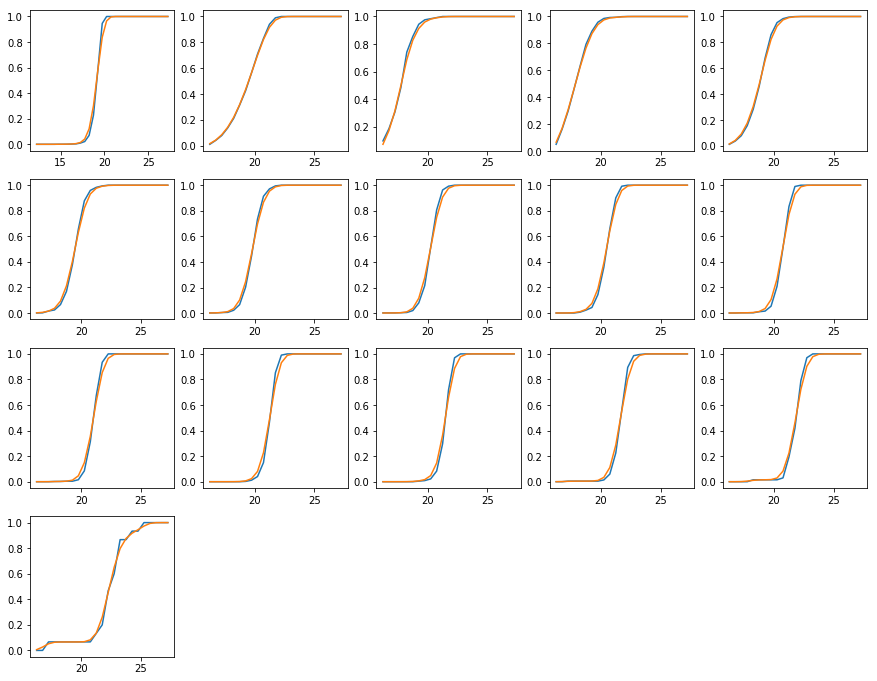

In [215]:
plt.rcParams["figure.figsize"] = (15,15)
for i, q_m_k in enumerate(q_m):
    subplot(5,5,i+1)
    plot(centers[i], q_m_old[i])
    plot(centers[i], np.cumsum(q_m_k))

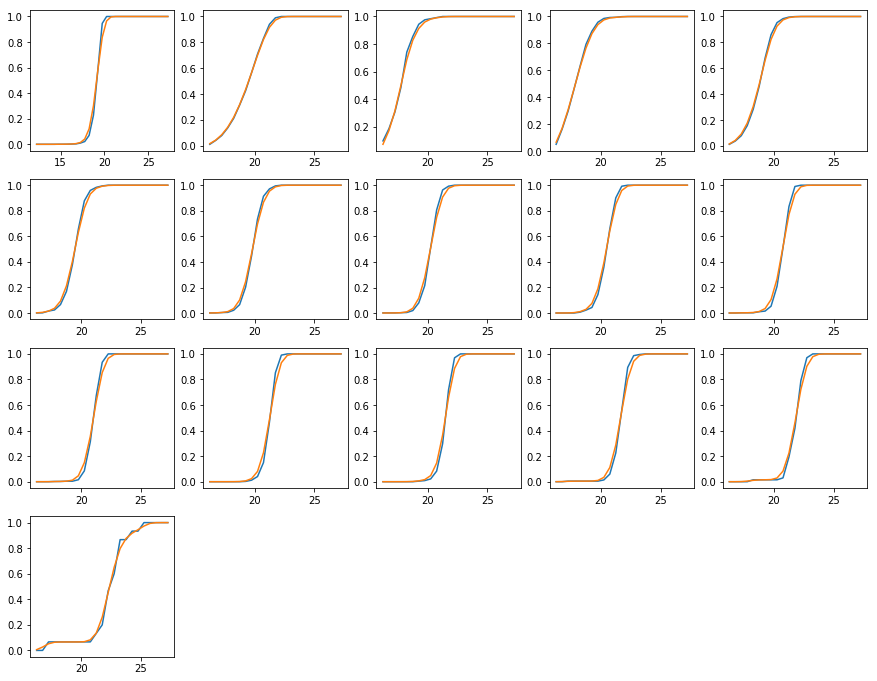

In [216]:
plt.rcParams["figure.figsize"] = (15,15)
for i, q_m_k in enumerate(q_m):
    subplot(5,5,i+1)
    plot(centers[i], q_m_old[i])
    plot(centers[i], np.cumsum(q_m_k))

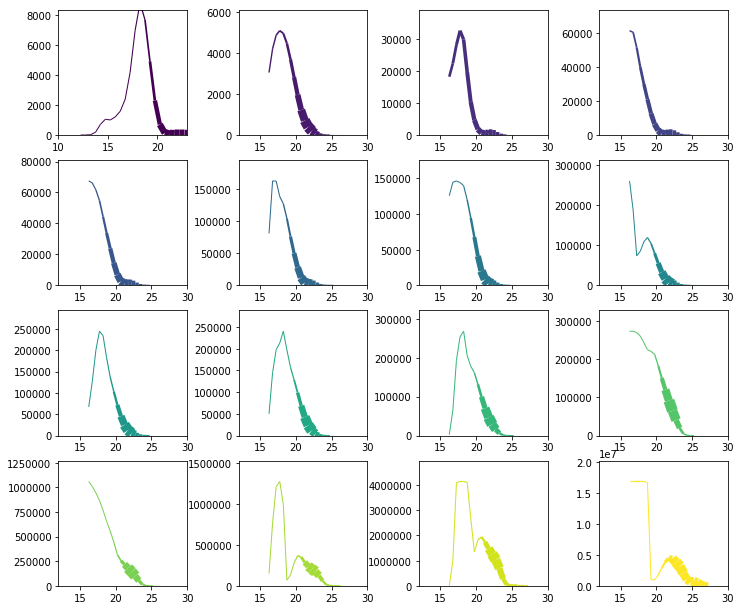

In [217]:
plt.rcParams["figure.figsize"] = (12,10)

from matplotlib import cm
from matplotlib.collections import LineCollection

cm_subsection = linspace(0., 1., 16) 
colors = [ cm.viridis(x) for x in cm_subsection ]

low = np.nonzero(centers[1] >= 15)[0][0]
high = np.nonzero(centers[1] >= 22.2)[0][0]

fig, a = plt.subplots()

for i, q_m_k in enumerate(q_m):
    #plot(centers[i], q_m_old[i]/n_m_old[i])
    a = subplot(4,4,i+1)
    if i not in [-1]:
        n_m_aux = n_m[i]/np.sum(n_m[i])
        lwidths = (n_m_aux/np.max(n_m_aux)*10).astype(float) + 1
        #print(lwidths)
        
        y_aux = q_m_k/n_m[i]
        factor = np.max(y_aux[low:high])
        y = y_aux
        #print(y)
        x = centers[i]
        
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        lc = LineCollection(segments, linewidths=lwidths, color=colors[i])
        
        a.add_collection(lc)
        
        #plot(centers[i], x/factor, color=colors[i-1])
        xlim([12, 30])
        if i == 0:
            xlim([10, 23])
        ylim([0, 1.2*factor])

subplots_adjust(left=0.125, 
                bottom=0.1, 
                right=0.9, 
                top=0.9,
                wspace=0.4, 
                hspace=0.2)

* https://stackoverflow.com/questions/8931268/using-colormaps-to-set-color-of-line-in-matplotlib
* https://stackoverflow.com/questions/19390895/matplotlib-plot-with-variable-line-width
* https://stackoverflow.com/questions/432112/is-there-a-numpy-function-to-return-the-first-index-of-something-in-an-array

### Save intermediate parameters

if save_intermediate:
    pickle.dump([bin_list, centers, Q_0_colour, n_m_old, q_m_old], 
                open("{}/lofar_params_cumsum_2.pckl".format(idp), 'wb'))
    pickle.dump([bin_list, centers, Q_0_colour, n_m, q_m], 
                open("{}/lofar_params_2.pckl".format(idp), 'wb'))

### Prepare for ML

In [219]:
selection = ~np.isnan(combined["category"]) # Avoid the two dreaded sources with no actual data
catalogue = combined[selection]

In [220]:
radius = 15

In [221]:
def apply_ml(i, likelihood_ratio_function):
    idx_0 = idx_i[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    
    category = catalogue["category"][idx_0].astype(int)
    mag = catalogue["m_gpc1_i"][idx_0]
    mag[category == 0] = catalogue["m_irac_i1"][idx_0][category == 0]
    
    lofar_ra = lofar[i]["RA"]
    lofar_dec = lofar[i]["DEC"]
    lofar_pa = lofar[i]["PA"]
    lofar_maj_err = lofar[i]["E_Maj"]
    lofar_min_err = lofar[i]["E_Min"]
    c_ra = catalogue["ra"][idx_0]
    c_dec = catalogue["dec"][idx_0]
    c_ra_err = 1.0
    c_dec_err = 1.0
    
    sigma, sigma_maj, sigma_min = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)

    lr_0 = likelihood_ratio_function(mag, d2d_0.arcsec, sigma, category)
    if len(lr_0) == 0:

        result = [np.nan,np.nan,np.nan,np.nan,np.nan]
        return result
    chosen_index = np.argmax(lr_0)
    lr_sum = np.sum(lr_0)
    rel = lr_0/(lr_sum + (1-Q0_i))
    helpid = catalogue['help_id'][idx_0][0]
    result = [combined_aux_index[selection][idx_0[chosen_index]], # Index
              (d2d_0.arcsec)[chosen_index],                        # distance
              lr_0[chosen_index],
              rel[chosen_index],
              helpid]                                  # LR
    return result

In [222]:
def apply_ml_all(i, likelihood_ratio_function):
    idx_0 = idx_i[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    
    category = catalogue["category"][idx_0].astype(int)
    mag = catalogue["m_gpc1_i"][idx_0]
    mag[category == 0] = catalogue["m_irac_i1"][idx_0][category == 0]
    
    lofar_ra = lofar[i]["RA"]
    lofar_dec = lofar[i]["DEC"]
    lofar_pa = lofar[i]["PA"]
    lofar_maj_err = lofar[i]["E_Maj"]
    lofar_min_err = lofar[i]["E_Min"]
    c_ra = catalogue["ra"][idx_0]
    c_dec = catalogue["dec"][idx_0]
    c_ra_err = 1.0
    c_dec_err = 1.0
    
    sigma, sigma_maj, sigma_min = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)

    lr_0 = likelihood_ratio_function(mag, d2d_0.arcsec, sigma, category)
    if len(lr_0) == 0:

        result = [np.nan,np.nan,np.nan,np.nan,np.nan]
        return result
    chosen_index = np.argmax(lr_0)
    lr_sum = np.sum(lr_0)
    rel = lr_0/(lr_sum + (1-Q0_i))
    helpid = catalogue['help_id'][idx_0]
    result = [combined_aux_index[selection][idx_0], # Index
              (d2d_0.arcsec),                        # distance
              lr_0,
              rel,
              helpid]                                  # LR
    

        
    return result

### Run the cross-match

This will not need to be repeated after

In [223]:
idx_lofar, idx_i, d2d, d3d = search_around_sky(
    coords_lofar, coords_combined[selection], radius*u.arcsec)

In [224]:
idx_lofar_unique = np.unique(idx_lofar)

### Run the ML matching

In [225]:
likelihood_ratio = MultiMLEstimator(Q_0_colour, n_m, q_m, centers)

In [226]:
def ml(i):
    return apply_ml(i, likelihood_ratio)

In [227]:
res = parallel_process(idx_lofar_unique, ml, n_jobs=n_cpus)

100%|██████████| 25.7k/25.7k [04:36<00:00, 93.0it/s] 
100%|██████████| 25734/25734 [00:00<00:00, 223591.26it/s]


In [228]:
len(res)

25737

In [229]:
lofar["lr_index_2"] = np.nan
lofar["lr_dist_2"] = np.nan
lofar["lr_2"] = np.nan
lofar["lr_reliability_2"] = np.nan
lofar["helpid_2"] = ''

In [230]:
len(res)

25737

In [231]:
(lofar["lr_index_2"][idx_lofar_unique], 
 lofar["lr_dist_2"][idx_lofar_unique], 
 lofar["lr_2"][idx_lofar_unique],
 lofar["lr_reliability_2"][idx_lofar_unique],
 lofar["helpid_2"][idx_lofar_unique]) = list(map(list, zip(*res)))

/Users/im281/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: StringTruncateWarning: truncated right side string(s) longer than 1 character(s) during assignment


Get the new threshold for the ML matching. FIX THIS

In [232]:
lofar["lr_2"][np.isnan(lofar["lr_2"])] = 0

In [233]:
mask = ~np.isnan(lofar["lr_dist_2"])
threshold = np.percentile(lofar["lr_2"][mask], 100*(1 - q0_total))
#manual_q0 = 0.65
#threshold = np.percentile(lofar["lr_2"], 100*(1 - manual_q0))

In [234]:
threshold # Old: 0.69787

15.835436524005209

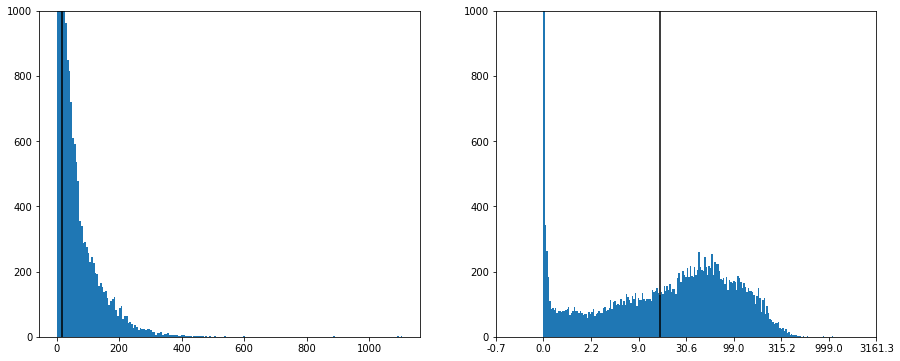

In [235]:
plt.rcParams["figure.figsize"] = (15,6)
subplot(1,2,1)
hist(lofar[lofar["lr_2"] != 0]["lr_2"], bins=200)
vlines([threshold], 0, 1000)
ylim([0,1000])
subplot(1,2,2)
hist(np.log10(lofar[lofar["lr_2"] != 0]["lr_2"]+1), bins=200)
vlines(np.log10(threshold+1), 0, 1000)
ticks, _ = xticks()
xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
ylim([0,1000]);

In [236]:
lofar["lr_index_sel_2"] = lofar["lr_index_2"]
lofar["lr_index_sel_2"][lofar["lr_2"] < threshold] = np.nan

In [237]:
n_changes = np.sum((lofar["lr_index_sel_2"] != lofar["lr_index_1"]) & 
                   ~np.isnan(lofar["lr_index_sel_2"]) &
                   ~np.isnan(lofar["lr_index_1"]))

In [238]:
n_changes # Old: 382

82

Enter the results

In [239]:
# Clear aux columns
lofar["category"] = np.nan
lofar["m_irac_i1"] = np.nan
lofar["m_megacam_r"] = np.nan

c = ~np.isnan(lofar["lr_index_sel_2"])
indices = lofar["lr_index_sel_2"][c].astype(int)
lofar["category"][c] = combined[indices]["category"]
lofar["m_irac_i1"][c] = combined[indices]["m_irac_i1"]
lofar["m_megacam_r"][c] = combined[indices]["m_megacam_r"]

In [240]:
numbers_lofar_combined_bins = np.array([np.sum(lofar["category"] == c) 
                                        for c in range(len(numbers_combined_bins))])

In [241]:
numbers_lofar_combined_bins

array([3774, 2264,    3,  809, 1258,  695,  715,  681,  677,  674,  595,
        470,  253,  239,   74,   15])

### Save intermediate data

if save_intermediate:
    lofar.write("{}/lofar_m2.fits".format(idp), format="fits")

## Iterate until convergence

In [171]:
rerun_iter = False

In [172]:
if rerun_iter:
    lofar = Table.read("{}/lofar_m2.fits".format(idp))
    bin_list, centers, Q_0_colour, n_m, q_m = pickle.load(open("{}/lofar_params_2.pckl".format(idp), 'rb'))
    inter_data_list = glob("{}/lofar_m*.fits".format(idp))
    # Remove data
    for inter_data_file in inter_data_list:
        if inter_data_file[-7:-5] not in ["m1", "m2"]:
            #print(inter_data_file)
            os.remove(inter_data_file)
    # Remove images
    images_list = glob("{}/*.png".format(idp))
    for images in images_list:
        #print(images)
        os.remove(images)
    # Remove parameters
    inter_param_list = glob("{}/lofar_params_*.pckl".format(idp))
    for inter_param_file in inter_param_list:
        if inter_param_file[-7:-5] not in ["1i", "w1", "_2"]:
            #print(inter_param_file)
            os.remove(inter_param_file)

In [173]:
radius = 15. 

In [242]:
from matplotlib import pyplot as plt

In [243]:
Table.write(lofar,'data/xmatch_all_preiter_20181106.fits')

In [244]:
def plot_q_n_m(q_m, n_m):
    fig, a = plt.subplots()

    for i, q_m_k in enumerate(q_m):
        #plot(centers[i], q_m_old[i]/n_m_old[i])
        a = subplot(4,4,i+1)
        if i not in [-1]:
            n_m_aux = n_m[i]/np.sum(n_m[i])
            lwidths = (n_m_aux/np.max(n_m_aux)*10).astype(float) + 1
            #print(lwidths)

            y_aux = q_m_k/n_m[i]
            factor = np.max(y_aux[low:high])
            y = y_aux
            #print(y)
            x = centers[i]

            points = np.array([x, y]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)

            lc = LineCollection(segments, linewidths=lwidths, color=colors[i])

            a.add_collection(lc)

            #plot(centers[i], x/factor, color=colors[i-1])
            xlim([12, 30])
            if i == 0:
                xlim([10, 23])
            ylim([0, 1.2*factor])

    subplots_adjust(left=0.125, 
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9,
                    wspace=0.4, 
                    hspace=0.2)
    return fig

In [ ]:
for j in range(10):
    iteration = j+3 
    print("Iteration {}".format(iteration))
    print("=============")
    ## Get new parameters
    # Number of matched sources per bin
    numbers_lofar_combined_bins = np.array([np.sum(lofar["category"] == c) 
                                            for c in range(len(numbers_combined_bins))])
    print("numbers_lofar_combined_bins")
    print(numbers_lofar_combined_bins)
    # q_0
    Q_0_colour_est = numbers_lofar_combined_bins/len(lofar) ### Q_0
    Q_0_colour = q0_min_level(Q_0_colour_est, min_level=0.001)
    print("Q_0_colour")
    print(Q_0_colour)
    q0_total = np.sum(Q_0_colour)
    print("Q_0_total: ", q0_total)
    # q_m_old
    q_m_old = []
    # W1 only sources
    q_m_old.append(get_q_m(lofar["m_irac_i1"][lofar["category"] == 0], 
                   bin_list_w1, numbers_lofar_combined_bins[0], 
                   n_m_old[0], field.area, radius=radius))
    # Rest of the sources
    for i in range(1, len(numbers_lofar_combined_bins)):
        q_m_old.append(get_q_m(lofar["m_megacam_r"][lofar["category"] == i], 
                       bin_list_i, numbers_lofar_combined_bins[i],
                       n_m_old[i], field.area, radius=radius))
    # q_m
    q_m = []
    # W1 only sources
    q_m.append(get_q_m_kde(lofar["m_irac_i1"][lofar["category"] == 0], 
                   centers[0], radius=radius, bandwidth=bandwidth_colour[0]))
    # Rest of the sources
    for i in range(1, len(numbers_lofar_combined_bins)):
        q_m.append(get_q_m_kde(lofar["m_megacam_r"][lofar["category"] == i], 
                       centers[i], radius=radius, bandwidth=bandwidth_colour[i]))
    '''# Save new parameters
    if save_intermediate:
        pickle.dump([bin_list, centers, Q_0_colour, n_m_old, q_m_old], 
                    open("{}/lofar_params_cumsum_{}.pckl".format(idp, iteration), 'wb'))
        pickle.dump([bin_list, centers, Q_0_colour, n_m, q_m], 
                    open("{}/lofar_params_{}.pckl".format(idp, iteration), 'wb'))'''
    if plot_intermediate:
        fig = plt.figure(figsize=(15,15))
        for i, q_m_k in enumerate(q_m):
            plt.subplot(5,5,i+1)
            plt.plot(centers[i], q_m_k)
        #plt.savefig('{}/q0_{}.png'.format(idp, iteration))
        del fig
        fig = plt.figure(figsize=(15,15))
        for i, q_m_k in enumerate(q_m):
            plt.subplot(5,5,i+1)
            plt.plot(centers[i], q_m_k/n_m[i])
        #plt.savefig('{}/q_over_n_{}.png'.format(idp, iteration))
        del fig
        fig = plot_q_n_m(q_m, n_m)
        #plt.savefig('{}/q_over_n_nice_{}.png'.format(idp, iteration))
        del fig
    ## Define new likelihood_ratio
    likelihood_ratio = MultiMLEstimator(Q_0_colour, n_m, q_m, centers)
    def ml(i):
        return apply_ml(i, likelihood_ratio)
    ## Run the ML
    res = parallel_process(idx_lofar_unique, ml, n_jobs=n_cpus)
    lofar["lr_index_{}".format(iteration)] = np.nan
    lofar["lr_dist_{}".format(iteration)] = np.nan
    lofar["lr_{}".format(iteration)] = np.nan
    lofar["lr_reliability_{}".format(iteration)] = np.nan
    lofar["helpid_{}".format(iteration)] = ''
    (lofar["lr_index_{}".format(iteration)][idx_lofar_unique], 
     lofar["lr_dist_{}".format(iteration)][idx_lofar_unique], 
     lofar["lr_{}".format(iteration)][idx_lofar_unique],
     lofar["lr_reliability_{}".format(iteration)][idx_lofar_unique],
     lofar["helpid_{}".format(iteration)][idx_lofar_unique]) = list(map(list, zip(*res)))
    lofar["lr_{}".format(iteration)][np.isnan(lofar["lr_{}".format(iteration)])] = 0
    ## Get and apply the threshold
    threshold = np.percentile(lofar["lr_{}".format(iteration)], 100*(1 - q0_total))
    #threshold = get_threshold(lofar[lofar["lr_{}".format(iteration)] != 0]["lr_{}".format(iteration)])
    print("Threshold: ", threshold)
    if plot_intermediate:
        fig = plt.figure(figsize=(15,6))
        plt.subplot(1,2,1)
        plt.hist(lofar[lofar["lr_{}".format(iteration)] != 0]["lr_{}".format(iteration)], bins=200)
        plt.vlines([threshold], 0, 1000)
        plt.ylim([0,1000])
        plt.subplot(1,2,2)
        plt.hist(np.log10(lofar[lofar["lr_{}".format(iteration)] != 0]["lr_{}".format(iteration)]+1), bins=200)
        plt.vlines(np.log10(threshold+1), 0, 1000)
        ticks, _ = plt.xticks()
        plt.xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
        plt.ylim([0,1000])
        #plt.savefig('{}/lr_distribution_{}.png'.format(idp, iteration))
        del fig
    ## Apply the threshold
    lofar["lr_index_sel_{}".format(iteration)] = lofar["lr_index_{}".format(iteration)]
    lofar["lr_index_sel_{}".format(iteration)][lofar["lr_{}".format(iteration)] < threshold] = np.nan
    ## Enter changes into the catalogue
    # Clear aux columns
    lofar["category"] = np.nan
    lofar["m_irac_i1"] = np.nan
    lofar["m_megacam_r"] = np.nan
    # Update data
    c = ~np.isnan(lofar["lr_index_sel_{}".format(iteration)])
    indices = lofar["lr_index_sel_{}".format(iteration)][c].astype(int)
    lofar["category"][c] = combined[indices]["category"]
    lofar["m_irac_i1"][c] = combined[indices]["m_irac_i1"]
    lofar["m_megacam_r"][c] = combined[indices]["m_megacam_r"]
    '''# Save the data
    if save_intermediate:
        lofar.write("{}/lofar_m{}.fits".format(idp, iteration), format="fits")'''
    ## Compute number of changes
    n_changes = np.sum((
            lofar["lr_index_sel_{}".format(iteration)] != lofar["lr_index_sel_{}".format(iteration-1)]) & 
            ~np.isnan(lofar["lr_index_sel_{}".format(iteration)]) &
            ~np.isnan(lofar["lr_index_sel_{}".format(iteration-1)]))
    print("N changes: ", n_changes)
    t_changes = np.sum((
            lofar["lr_index_sel_{}".format(iteration)] != lofar["lr_index_sel_{}".format(iteration-1)]))
    print("T changes: ", t_changes)
    ## Check changes
    plt.show()
    if n_changes == 0:
        break
    else:
        print("******** continue **********")

In [ ]:
numbers_lofar_combined_bins = np.array([np.sum(lofar["category"] == c) 
                                        for c in range(len(numbers_combined_bins))])
numbers_lofar_combined_bins

if save_intermediate:
    pickle.dump([numbers_lofar_combined_bins, numbers_combined_bins], 
                open("{}/numbers_{}.pckl".format(idp, iteration), 'wb'))

In [ ]:
good = False

In [ ]:
if good:
    if os.path.exists("lofar_params.pckl"):
        os.remove("lofar_params.pckl")
    copyfile("{}/lofar_params_{}.pckl".format(idp, iteration), "lofar_params.pckl")

In [ ]:
np.sum(~(lofar['lr_index_6'] == lofar['lr_index_w1']))

In [ ]:
lofar[0]

In [ ]:
inds = lofar['lr_index_sel_2']
mask = np.isnan(inds)
inds[mask] = 0
idremove = combined['help_id'][0]
ind = np.array(inds.astype('int'))
idcol = Column(combined[ind]['help_id'])
mask = idcol==idremove
idcol[mask] = np.nan
oldmatch = lofar.copy()
oldmatch.add_column(idcol,name='help_id')
oldmatch_table = join(oldmatch,combined,keys='help_id')

In [ ]:
mask = oldmatch_table['lr_index_sel_6'] != oldmatch_table['lr_index_sel_2']
Table.write(oldmatch_table[mask],'xmatch_lofar_master_col_2.fits',format='fits',overwrite=True)

In [245]:
original = lofar.copy()

In [246]:
lofar = original.copy()

In [267]:
lofar[lofar['category']==1]

Source_id,Isl_id,RA,E_RA,DEC,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,RA_max,E_RA_max,DEC_max,E_DEC_max,Maj,E_Maj,Min,E_Min,PA,E_PA,Maj_img_plane,E_Maj_img_plane,Min_img_plane,E_Min_img_plane,PA_img_plane,E_PA_img_plane,DC_Maj,E_DC_Maj,DC_Min,E_DC_Min,DC_PA,E_DC_PA,DC_Maj_img_plane,E_DC_Maj_img_plane,DC_Min_img_plane,E_DC_Min_img_plane,DC_PA_img_plane,E_DC_PA_img_plane,Isl_Total_flux,E_Isl_Total_flux,Isl_rms,Isl_mean,Resid_Isl_rms,Resid_Isl_mean,S_Code,lr_i,lr_dist_i,lr_index_i,lr_reliability_i,helpid_i,lr_index_sel_i,lr_w1,lr_dist_w1,lr_index_w1,lr_reliability_w1,helpid_w1,lr_index_sel_w1,lr_index_1,lr_dist_1,lr_1,lr_type_1,category,m_irac_i1,m_gpc1_i,lr_index_2,lr_dist_2,lr_2,lr_reliability_2,helpid_2,lr_index_sel_2
,,deg,deg,deg,deg,Jy,Jy,Jy / beam,Jy / beam,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,Jy,Jy,Jy / beam,Jy / beam,Jy / beam,Jy / beam,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,str1,float64,float64,float64,float64,float64,str1,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,str1,float64
1916,1938,166.55785516348735,0.00010789847552528717,57.296924632618676,9.493602138735394e-05,0.00038416180896986733,4.435000414442208e-05,0.0002522871226264514,2.913600080568459e-05,166.55785516348735,0.00010789847552528717,57.296924632618676,9.493602138735394e-05,0.002156034958646618,0.00025838983900020496,0.001963987390371005,0.0002185690534061255,113.69734762324431,57.2351476020348,0.0021544292757879366,0.00025838983900020496,0.001963289579404404,0.0002185690534061255,109.65253082056199,57.2351476020348,0.0013662235910663237,0.00025838983900020496,0.0010380239557068124,0.0002185690534061255,113.6973476232443,57.2351476020348,0.0013652061113965004,0.00025838983900020496,0.0010376551425305715,0.0002185690534061255,109.65253082056198,57.2351476020348,0.0003048386726426645,3.313056013782292e-05,2.7148198569193482e-05,0.0,3.673113496915903e-06,-2.0785012821988857e-08,S,58.225612757824216,0.5545585782421273,4270337.0,0.9907905712588074,H,4270337.0,0.0,nan,nan,nan,,nan,4270337.0,0.5545585782421273,58.225612757824216,1,1.0,nan,19.408100128173828,4270337.0,0.5545585782421273,36.90528565625714,0.9855471423147033,H,4270337.0
1971,1993,166.50861138879347,6.711077286610172e-05,57.267376324465495,9.27921235550212e-05,0.0029844717343011982,6.468535835140565e-05,0.000794688422050747,3.2057956559583545e-05,166.51039657987397,6.711077286610172e-05,57.26738263027616,9.27921235550212e-05,0.004302252573931128,0.00025414394592087464,0.0021343723966002724,9.017543727884383e-05,60.895586680663605,4.544120751049195,0.004297992059389779,0.00025414394592087464,0.0021341658571797637,9.017543727884383e-05,56.893468506162236,4.544120751049195,0.003965613393794464,0.00025414394592087464,0.0013331279271688343,9.017543727884383e-05,60.8955866806636,4.544120751049195,0.003961686252695917,0.00025414394592087464,0.001332998922795536,9.017543727884383e-05,56.89346850616223,4.544120751049195,0.0027123230932180036,0.00010378116202042343,3.2057956559583545e-05,0.0,2.669216883077752e-05,1.0235689842374995e-06,M,33.02764704503982,1.2905906154034343,4270030.0,0.9392562907705042,H,4270030.0,0.0,nan,nan,nan,,nan,4270030.0,1.2905906154034343,33.02764704503982,1,1.0,nan,19.839399337768555,4270030.0,1.2905906154034343,19.305348203279827,0.9364143084642454,H,4270030.0
2013,2035,166.4536151277815,9.680750991160186e-05,57.05835136407979,9.231563564461702e-05,0.0006155835585309456,4.1868890884657664e-05,0.0003374931307879707,2.84584437716879e-05,166.4536151277815,9.680750991160186e-05,57.05835

In [261]:
np.min(lofar[mask_sel]['m_gpc1_i'])

/Users/im281/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


nan

In [258]:
np.sum(~np.isnan(lofar[mask_sel]["m_gpc1_i"][lofar[mask_sel]["category"] == i]))

2252

In [249]:
def apply_ml_all(i, likelihood_ratio_function):
    
    idx_0 = idx_i[idx_lofar == i]
    d2d_0 = d2d[idx_lofar == i]
    if len(idx_0) == 0:
        print('no sources within search radius')
        return [],0
    
    category = catalogue["category"][idx_0].astype(int)
    mag = catalogue["m_gpc1_i"][idx_0]
    mag[category == 0] = catalogue["m_irac_i1"][idx_0][category == 0]
    
    lofar_ra = lofar[i]["RA"]
    lofar_dec = lofar[i]["DEC"]
    lofar_pa = lofar[i]["PA"]
    lofar_maj_err = lofar[i]["E_Maj"]
    lofar_min_err = lofar[i]["E_Min"]
    c_ra = catalogue["ra"][idx_0]
    c_dec = catalogue["dec"][idx_0]
    c_ra_err = 1.0
    c_dec_err = 1.0
    
    sigma, sigma_maj, sigma_min = get_sigma_all(lofar_maj_err, lofar_min_err, lofar_pa, 
                      lofar_ra, lofar_dec, 
                      c_ra, c_dec, c_ra_err, c_dec_err)

    lr_0 = likelihood_ratio_function(mag, d2d_0.arcsec, sigma, category)

    chosen_index = np.argmax(lr_0)
    lr_sum = np.sum(lr_0)
    rel = lr_0/(lr_sum + (1-Q0_i))
    helpid = catalogue['help_id'][idx_0]
    sourceid = (np.zeros(len(lr_0)) + np.unique(lofar['Source_id'])[i]).astype('int')
    col_index = Column(combined_aux_index[selection][idx_0],name='lr_index_{}'.format(iteration))
    col_d2d = Column(d2d_0.arcsec,name='lr_dist_{}'.format(iteration))
    col_lr = Column(lr_0,name='lr_{}'.format(iteration))
    col_rel = Column(rel,name='lr_reliability_{}'.format(iteration))
    col_sourceid = Column(sourceid,name='Source_id')
    col_helpid = Column(helpid,name='help_id')

    #print(col_sourceid)
    #print(col_index,col_d2d,col_lr,col_rel,col_sourceid,col_helpid)
    
    temp = Table([col_index,col_d2d,col_lr,col_rel,col_sourceid,col_helpid])

    lrs = np.max(col_lr)

    return (temp,lrs)

    #return (result)

Iteration 3
numbers_lofar_combined_bins
[   9 2252    3  801 1246  683  695  655  625  602  518  424  229  218
   68   15]
Q_0_colour
[0.001      0.08078924 0.001      0.02873543 0.04469955 0.02450224
 0.02493274 0.02349776 0.02242152 0.02159641 0.01858296 0.01521076
 0.00821525 0.00782063 0.00243946 0.001     ]
Q_0_total:  0.3264439461883408
no sources within search radius


IndexError: list index out of range

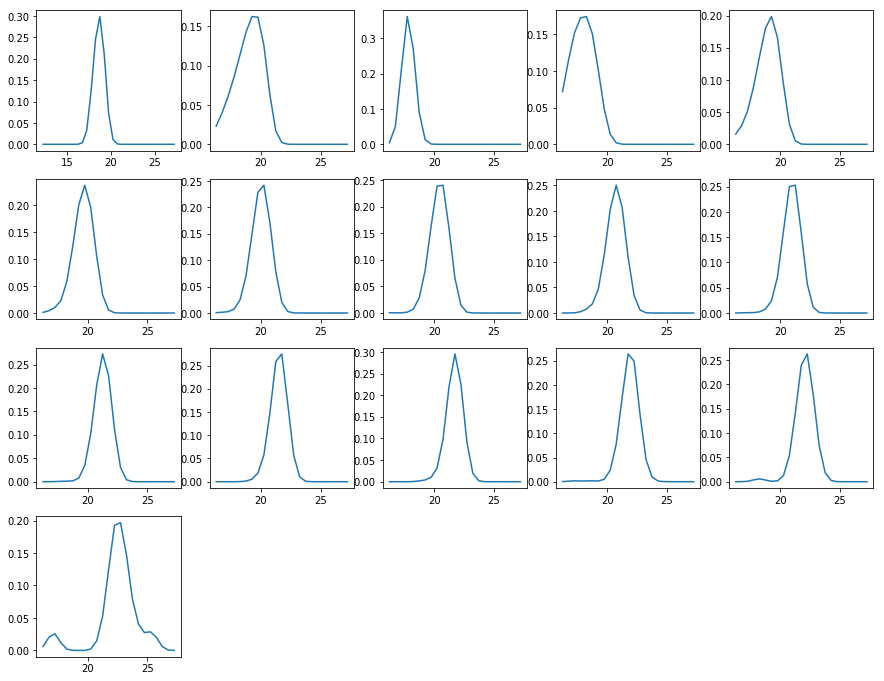

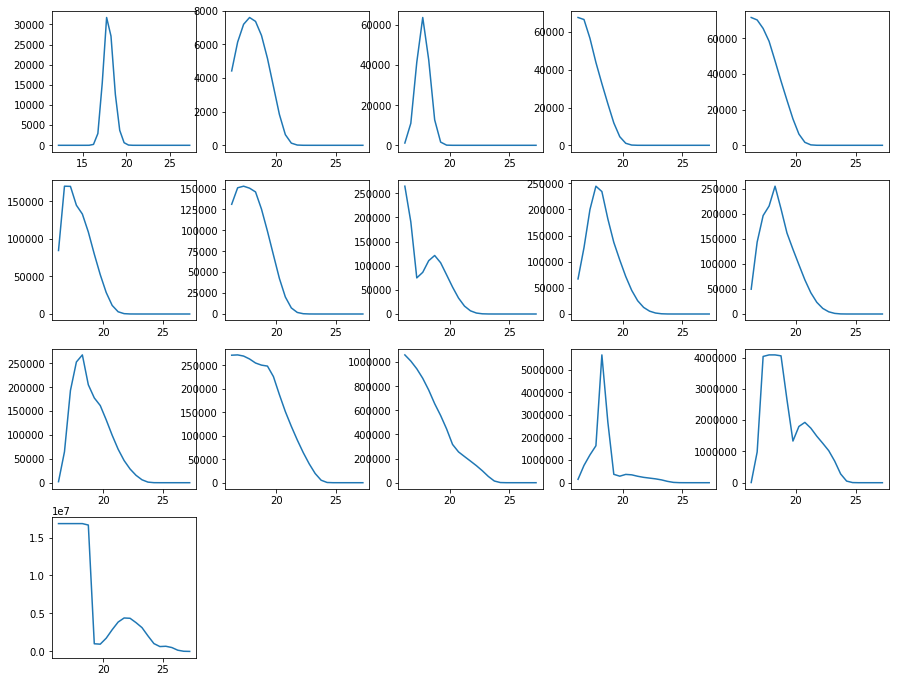

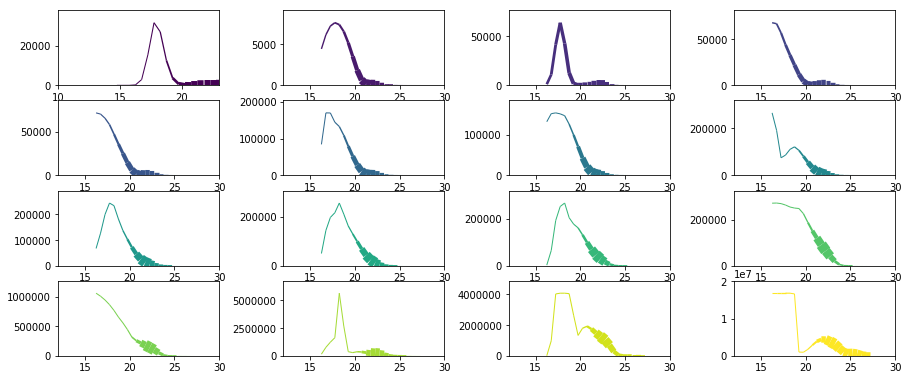

In [269]:
for j in range(10):
    iteration = j+3 
    print("Iteration {}".format(iteration))
    print("=============")
    ## Get new parameters
    # Number of matched sources per bin
    if j==0:
        mask_sel = ~np.isnan(lofar['m_gpc1_i'])
    else:
        mask_sel = lofar['lr_sel_{}'.format(iteration-1)]
    numbers_lofar_combined_bins = np.array([np.sum(lofar[mask_sel]["category"] == c) 
                                            for c in range(len(numbers_combined_bins))])
    print("numbers_lofar_combined_bins")
    print(numbers_lofar_combined_bins)
    # q_0
    Q_0_colour_est = numbers_lofar_combined_bins/len(np.unique(lofar['Source_id'])) ### Q_0
    Q_0_colour = q0_min_level(Q_0_colour_est, min_level=0.001)
    print("Q_0_colour")
    print(Q_0_colour)
    q0_total = np.sum(Q_0_colour)
    print("Q_0_total: ", q0_total)
    # q_m_old
    q_m_old = []
    # W1 only sources
    q_m_old.append(get_q_m(lofar[mask_sel]["m_irac_i1"][lofar[mask_sel]["category"] == 0], 
                   bin_list_w1, numbers_lofar_combined_bins[0], 
                   n_m_old[0], field.area, radius=radius))
    # Rest of the sources
    for i in range(1, len(numbers_lofar_combined_bins)):
        q_m_old.append(get_q_m(lofar[mask_sel]["m_gpc1_i"][lofar[mask_sel]["category"] == i], 
                       bin_list_i, numbers_lofar_combined_bins[i],
                       n_m_old[i], field.area, radius=radius))
    # q_m
    q_m = []
    # W1 only sources
    q_m.append(get_q_m_kde(lofar[mask_sel]["m_irac_i1"][lofar[mask_sel]["category"] == 0], 
                   centers[0], radius=radius, bandwidth=bandwidth_colour[0]))
    # Rest of the sources
    for i in range(1, len(numbers_lofar_combined_bins)):
        q_m.append(get_q_m_kde(lofar[mask_sel]["m_gpc1_i"][lofar[mask_sel]["category"] == i], 
                       centers[i], radius=radius, bandwidth=bandwidth_colour[i]))
    '''# Save new parameters
    if save_intermediate:
        pickle.dump([bin_list, centers, Q_0_colour, n_m_old, q_m_old], 
                    open("{}/lofar[mask_sel]_params_cumsum_{}.pckl".format(idp, iteration), 'wb'))
        pickle.dump([bin_list, centers, Q_0_colour, n_m, q_m], 
                    open("{}/lofar[mask_sel]_params_{}.pckl".format(idp, iteration), 'wb'))'''
    if plot_intermediate:
        fig = plt.figure(figsize=(15,15))
        for i, q_m_k in enumerate(q_m):
            plt.subplot(5,5,i+1)
            plt.plot(centers[i], q_m_k)
        #plt.savefig('{}/q0_{}.png'.format(idp, iteration))
        del fig
        fig = plt.figure(figsize=(15,15))
        for i, q_m_k in enumerate(q_m):
            plt.subplot(5,5,i+1)
            plt.plot(centers[i], q_m_k/n_m[i])
        #plt.savefig('{}/q_over_n_{}.png'.format(idp, iteration))
        del fig
        fig = plot_q_n_m(q_m, n_m)
        #plt.savefig('{}/q_over_n_nice_{}.png'.format(idp, iteration))
        del fig
    ## Define new likelihood_ratio
    likelihood_ratio = MultiMLEstimator(Q_0_colour, n_m, q_m, centers)
    def ml(i):
        return apply_ml_all(i, likelihood_ratio)
    ## Run the ML
    '''lofar[mask_sel]["lr_index_{}".format(iteration)] = np.nan
    lofar[mask_sel]["lr_dist_{}".format(iteration)] = np.nan
    lofar[mask_sel]["lr_{}".format(iteration)] = np.nan
    lofar[mask_sel]["lr_reliability_{}".format(iteration)] = np.nan
    lofar[mask_sel]["helpid_{}".format(iteration)] = '''''
        
    
    #res = parallel_process(idx_lofar[mask_sel]_unique, ml, n_jobs=n_cpus)
    nomatch,_ = ml(0)
    nomatch = nomatch[0]
    for n,val in enumerate(nomatch):
        nomatch[n]=-99
    res,lr = ml(0)
    
    lrs = []
    lrs.append(lr)
    if j==0:
        for i in range(len(np.unique(lofar['Source_id'])-1)):
            if i%1000==0:
                print(i)
            temp,lr = ml(i+1)
            if len(temp)==0:
                continue
            res = astropy.table.vstack([res,temp])
            lrs.append(lr)
    
    if j>0:
        for i in range(len(np.unique(lofar['Source_id'])-1)):
            if i%1000==0:
                print(i)
            temp,lr = ml(i+1)
            if len(temp)==0:
                temp=nomatch
            res = astropy.table.vstack([res,temp])
            lrs.append(lr)
    lrs = np.array(lrs)

    '''if j==0:
        lofar[mask_sel] = join(lofar[mask_sel],res,keys='Source_id',join_type='outer')
    if j!=0:
        lofar[mask_sel] = join(lofar[mask_sel],res,keys='help_id',join_type='outer')
    print(res)
    (lofar[mask_sel]["lr_index_{}".format(iteration)][idx_lofar[mask_sel]_unique], 
     lofar[mask_sel]["lr_dist_{}".format(iteration)][idx_lofar[mask_sel]_unique], 
     lofar[mask_sel]["lr_{}".format(iteration)][idx_lofar[mask_sel]_unique],
     lofar[mask_sel]["lr_reliability_{}".format(iteration)][idx_lofar[mask_sel]_unique],
     lofar[mask_sel]["helpid_{}".format(iteration)][idx_lofar[mask_sel]_unique]) = list(map(list, zip(*res)))'''
    res["lr_{}".format(iteration)][np.isnan(res["lr_{}".format(iteration)])] = 0
    ## Get and apply the threshold
    mask = lrs>0
    threshold = np.percentile(lrs[mask], 100*(1 - q0_total))
    print("Threshold: ", threshold)
                   
    res["lr_sel_{}".format(iteration)] = False
    
    for n,ids in enumerate(np.unique(res['Source_id'])):
        mask = res['Source_id']==ids
        if np.sum(mask)==1:
            if np.isnan(res['lr_{}'.format(iteration)][mask])<=0:
                continue
        chosen_index = np.argmax(res['lr_{}'.format(iteration)][mask])
        helpid = res['help_id'][mask][chosen_index]
        helpmask = res['help_id']==helpid
        helpindex = np.argmax(helpmask)

        res['lr_sel_{}'.format(iteration)][helpindex] = True               
    
    if j==0:
        lofar = join(lofar,res,keys='Source_id',join_type='outer')
    else:
        res.remove_column('Source_id')
        lofar = astropy.table.hstack([lofar,res])
        
    def completeness(lr, threshold, q0):
        n = len(lr)
        lrt = lr[lr < threshold]
        return 1. - np.sum((q0 * lrt)/(q0 * lrt + (1 - q0)))/(float(n)*q0)
    
    def reliability(lr, threshold, q0):
        n = len(lr)
        lrt = lr[lr > threshold]
        return 1. - np.sum((1. - q0)/(q0 * lrt + (1 - q0)))/(float(n)*q0)
    completeness_v = np.vectorize(completeness, excluded=[0])
    reliability_v = np.vectorize(reliability, excluded=[0])
    thresholds = np.arange(0., 10., 0.001)
    mask = lofar['lr_sel_{}'.format(iteration)] & (lofar['lr_{}'.format(iteration)]>0)
    lr_temp = lofar['lr_{}'.format(iteration)][mask]
    completeness_t = completeness_v(lr_temp , thresholds, Q0)
    reliability_t = reliability_v(lr_temp , thresholds, Q0)
    index = np.argmin(abs(completeness_t-reliability_t))
    threshold = thresholds[index]
    #threshold = get_threshold(lofar[mask_sel][lofar[mask_sel]["lr_{}".format(iteration)] != 0]["lr_{}".format(iteration)])
    print("updated Threshold: ", threshold)
    mask = lofar['lr_sel_{}'.format(iteration)]
    for n in range(np.sum(mask)):
        if lofar[mask]['lr_{}'.format(iteration)][n]<threshold:
            lofar[mask]['lr_sel_{}'.format(iteration)][n] = False
    
    if plot_intermediate:
        fig = plt.figure(figsize=(15,6))
        plt.subplot(1,2,1)
        plt.hist(lofar[lofar["lr_{}".format(iteration)] != 0]["lr_{}".format(iteration)], bins=200)
        plt.vlines([threshold], 0, 1000)
        plt.ylim([0,1000])
        plt.subplot(1,2,2)
        plt.hist(np.log10(lofar[lofar["lr_{}".format(iteration)] != 0]["lr_{}".format(iteration)]+1), bins=200)
        plt.vlines(np.log10(threshold+1), 0, 1000)
        ticks, _ = plt.xticks()
        plt.xticks(ticks, ["{:.1f}".format(10**t-1) for t in ticks])
        plt.ylim([0,1000])
        #plt.savefig('{}/lr_distribution_{}.png'.format(idp, iteration))
        del fig
    ## Apply the threshold

    ## Enter changes into the catalogue
    # Clear aux columns
    lofar["category"] = np.nan
    lofar["m_irac_i1"] = np.nan
    lofar["m_gpc1_i"] = np.nan
    # Update data
    c = ~np.isnan(lofar["lr_index_{}".format(iteration)])
    indices = lofar["lr_index_{}".format(iteration)][c].astype(int)
    lofar["category"][c] = combined[indices]["category"]
    lofar["m_irac_i1"][c] = combined[indices]["m_irac_i1"]
    lofar["m_gpc1_i"][c] = combined[indices]["m_gpc1_i"]
    '''# Save the data
    if save_intermediate:
        lofar[mask_sel].write("{}/lofar[mask_sel]_m{}.fits".format(idp, iteration), format="fits")'''
    ## Compute number of changes
    n_changes = np.sum((
            lofar["lr_index_{}".format(iteration)] != lofar["lr_index_{}".format(iteration-1)]) & 
            ~np.isnan(lofar["lr_index_{}".format(iteration)]) &
            ~np.isnan(lofar["lr_index_{}".format(iteration-1)]))
    print("N changes: ", n_changes)
    t_changes = np.sum((
            lofar["lr_index_{}".format(iteration)] != lofar["lr_index_{}".format(iteration-1)]))
    print("T changes: ", t_changes)
    ## Check changes
    plt.show()
    if n_changes == 0:
        break
    else:
        print("******** continue **********")

In [ ]:
nomatch,_ = ml(0)
nomatch = nomatch[0]
for n,val in enumerate(nomatch):
    nomatch[n]=-99
nomatch

In [ ]:
res

In [ ]:
threshold

In [ ]:
lofar

In [ ]:
Table.write(lofar,'data/xmatch_all_20181011.fits',format='fits')

In [ ]:
q0_total